In [16]:
# Require python>=3.9

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\submarine\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx4m\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

In [3]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT
import physics.multiphaseWLMA.multiphaseWLMA as multiphaseWLMA
import physics.multiphaseWLMA.iapws95_light.mixtureWLMA as mixtureWLMA

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer



os.chdir(target_dir)

## Data

In [7]:
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA5_atm{domidx}_{i}.pkl") # AV: WLMA5
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA6_atm{domidx}_{i}.pkl") # AV: WLMA5
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA7_atm{domidx}_{i}.pkl") # AV=5, +low-water limit: WLMA7
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA8_atm{domidx}_{i}.pkl") # AV=5, +low-water limit: WLMA7 dt=1/2500
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA9_atm{domidx}_{i}.pkl") # AV=0.3, +low-water limit: dt=1/300 +uplift, +PPL_energy
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA10_atm{domidx}_{i}.pkl") # AV=0.3, +low-water limit: dt=1/600 +uplift, +PPL_energy, +AV y_w x 10 strength,
  # triplepoint clipping in mix_soundspeed
# WLMA10 range: 0 to 480+
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA11_atm{domidx}_{i}.pkl") # AV=0.5/1.0, +low-water limit: dt=1/1400 +uplift, +PPL_energy, +AV y_w x 1.5 strength,
  # triplepoint clipping in mix_soundspeed, CARTESIAN, triplepoint clipping in main conservative..._bn, new mesh 
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA12_atm{domidx}_{i}.pkl") # AV=0.3, +low-water limit: dt=1/700 +uplift, +PPL_energy, +AV y_w x 1.5 strength,
  # triplepoint clipping in mix_soundspeed, CARTESIAN, triplepoint clipping in main conservative..._bn, new mesh, pseudo-solubility
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(
  f"lavalake1_atm{domidx}_{i}.pkl") # Lava lake derived from WLMA12 settings

# Initial condition state
physics0 = solver_from_multi(1,0).physics
x1, _ = mdtools.downsample(solver_from_multi(1,0))
U_ess1 = physics0.IC.get_state(physics0, x1, 0.0)
x2, _ = mdtools.downsample(solver_from_multi(2,0))
U_ess2 = physics0.IC.get_state(physics0, x2, 0.0)

x = np.concatenate((x1, x2), axis=0)
U_ess = np.concatenate((U_ess1, U_ess2), axis=0)

In [8]:
# Default construction
wlma = mixtureWLMA.WLMA()

In [23]:
''' (Copy for index 0) Compute substates from solver file '''
# solver = solver_from(100)

time_idx = 0 #50 #40

domain_read_list = [1, 2]

cat_x = []
cat_rho_mix = []
cat_ya = []
cat_yw = []
cat_ym = []
cat_u = []
cat_v = []
cat_steamfrac = []
cat_rhow = []
cat_p = []
cat_T = []
cat_psat = []
cat_E = []
cat_c = []
cat_alphaw = []
cat_aux = []

for dom_idx in domain_read_list:
  solver = solver_from_multi(dom_idx, time_idx)

  t = solver.time
  # JANK: manually reconstruct the downsampled conservative variables
  x, _U0 = mdtools.downsample(solver, "pDensityA")
  _, _U1 = mdtools.downsample(solver, "pDensityWv")
  _, _U2 = mdtools.downsample(solver, "pDensityM")
  _, _U3 = mdtools.downsample(solver, "XMomentum")
  _, _U4 = mdtools.downsample(solver, "YMomentum")
  _, _U5 = mdtools.downsample(solver, "Energy")

  rhow, p, T, c, alphaw = wlma.WLM_rhopT_native(
    np.concatenate((_U0, _U1, _U2), axis=-1),
    np.concatenate((_U3, _U4), axis=-1), _U5)
  # Compute saturation properties for each point in the downsample
  tuplize = lambda sat_obj: (sat_obj["psat"],
                            sat_obj["rho_satl"],
                            sat_obj["rho_satv"])
  # Compute saturation information as a list of tuples for each point
  sat_info = [tuplize(mixtureWLMA.float_mix_functions.prho_sat(_T))
              for _T in T.ravel()]
  # Define map to steam fraction
  fn_steamfrac = lambda rhow, sat_tup: np.clip(
   (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0
  )
  # Allocate psats, streamfrac
  psats = np.empty_like(rhow)
  steamfrac = np.empty_like(rhow)
  # Extract saturation pressures
  psats_tup, _, _ = zip(*sat_info)
  # Fill np arrays
  psats.ravel()[:] = np.array(psats_tup)
  steamfrac.ravel()[:] = list(map(fn_steamfrac, rhow.ravel(), sat_info))
  steamfrac = np.where(psats > 0, steamfrac, -1.0)

  rho_mix = _U0 + _U1 + _U2
  u = _U3 / rho_mix
  v = _U4 / rho_mix
  ya = _U0 / rho_mix
  yw = _U1 / rho_mix
  ym = _U2 / rho_mix

  # Wildcard quantity
  aux = np.empty_like(c)
  # Pure water sound speed
  aux.ravel()[:] = list(map(mixtureWLMA.float_mix_functions.sound_speed, rhow.ravel(), T.ravel()))

  cat_x.append(x)
  cat_rho_mix.append(rho_mix)
  cat_ya.append(ya)
  cat_yw.append(yw)
  cat_ym.append(ym)
  cat_u.append(u)
  cat_v.append(v)
  cat_steamfrac.append(steamfrac)
  cat_rhow.append(rhow)
  cat_p.append(p)
  cat_T.append(T)
  cat_psat.append(psats)
  cat_E.append(_U5)
  cat_c.append(c)
  cat_alphaw.append(alphaw)
  cat_aux.append(aux)

# Global assembly
x, rho_mix, ya, yw, ym, u, v, steamfrac, rhow, p, T, psats, U_E, c, alphaw, aux = [
  np.concatenate(cat_vec, axis=0) for cat_vec in (
    cat_x, cat_rho_mix, cat_ya, cat_yw, cat_ym,
    cat_u, cat_v, cat_steamfrac, cat_rhow, cat_p, cat_T, cat_psat, cat_E,
    cat_c, cat_alphaw, cat_aux
  )
]
velnorm = np.sqrt(u*u + v*v)

rho_mix0 = rho_mix
p0 = p
yw0 = yw
ya0 = ya

In [24]:
%matplotlib inline
''' Compute substates from solver file '''
# solver = solver_from(100)

time_idx = 658 #12 #50 #40

domain_read_list = [1, 2]

cat_x = []
cat_rho_mix = []
cat_ya = []
cat_yw = []
cat_ym = []
cat_u = []
cat_v = []
cat_steamfrac = []
cat_rhow = []
cat_p = []
cat_T = []
cat_psat = []
cat_E = []
cat_c = []
cat_alphaw = []
cat_aux = []

for dom_idx in domain_read_list:
  solver = solver_from_multi(dom_idx, time_idx)

  t = solver.time
  # JANK: manually reconstruct the downsampled conservative variables
  x, _U0 = mdtools.downsample(solver, "pDensityA")
  _, _U1 = mdtools.downsample(solver, "pDensityWv")
  _, _U2 = mdtools.downsample(solver, "pDensityM")
  _, _U3 = mdtools.downsample(solver, "XMomentum")
  _, _U4 = mdtools.downsample(solver, "YMomentum")
  _, _U5 = mdtools.downsample(solver, "Energy")

  rhow, p, T, c, alphaw = wlma.WLM_rhopT_native(
    np.concatenate((_U0, _U1, _U2), axis=-1),
    np.concatenate((_U3, _U4), axis=-1), _U5)
  # Compute saturation properties for each point in the downsample
  tuplize = lambda sat_obj: (sat_obj["psat"],
                            sat_obj["rho_satl"],
                            sat_obj["rho_satv"])
  # Compute saturation information as a list of tuples for each point
  sat_info = [tuplize(mixtureWLMA.float_mix_functions.prho_sat(_T))
              for _T in T.ravel()]
  # Define map to steam fraction
  fn_steamfrac = lambda rhow, sat_tup: np.clip(
   (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0
  )
  # Allocate psats, streamfrac
  psats = np.empty_like(rhow)
  steamfrac = np.empty_like(rhow)
  # Extract saturation pressures
  psats_tup, _, _ = zip(*sat_info)
  # Fill np arrays
  psats.ravel()[:] = np.array(psats_tup)
  steamfrac.ravel()[:] = list(map(fn_steamfrac, rhow.ravel(), sat_info))
  steamfrac = np.where(psats > 0, steamfrac, -1.0)

  rho_mix = _U0 + _U1 + _U2
  u = _U3 / rho_mix
  v = _U4 / rho_mix
  ya = _U0 / rho_mix
  yw = _U1 / rho_mix
  ym = _U2 / rho_mix

  # Wilcard quantity
  aux = np.empty_like(c)
  # Pure water sound speed
  aux.ravel()[:] = list(map(mixtureWLMA.float_mix_functions.sound_speed, rhow.ravel(), T.ravel()))

  cat_x.append(x)
  cat_rho_mix.append(rho_mix)
  cat_ya.append(ya)
  cat_yw.append(yw)
  cat_ym.append(ym)
  cat_u.append(u)
  cat_v.append(v)
  cat_steamfrac.append(steamfrac)
  cat_rhow.append(rhow)
  cat_p.append(p)
  cat_T.append(T)
  cat_psat.append(psats)
  cat_E.append(_U5)
  cat_c.append(c)
  cat_alphaw.append(alphaw)
  cat_aux.append(aux)

# Global assembly
x, rho_mix, ya, yw, ym, u, v, steamfrac, rhow, p, T, psats, U_E, c, alphaw, aux = [
  np.concatenate(cat_vec, axis=0) for cat_vec in (
    cat_x, cat_rho_mix, cat_ya, cat_yw, cat_ym,
    cat_u, cat_v, cat_steamfrac, cat_rhow, cat_p, cat_T, cat_psat, cat_E,
    cat_c, cat_alphaw, cat_aux
  )
]
velnorm = np.sqrt(u*u + v*v)

C:\Users\Fredric\AppData\Local\Temp\ipykernel_35164\2764226932.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0


In [17]:
''' Manually evaluate sound speed '''
_rhow, _p, _T = 997, 1e5, 300
params = { "vol_energy": 01231231.0,
          "rho_mix": 996,
          "yw": 1.0,
          "ya": 0.0,
          "K": wlma.K,
          "p_m0": wlma.p_m0,
          "rho_m0": wlma.rho_m0,
          "c_v_m0": wlma.c_v_m0,
          "R_a": wlma.R_a,
          "gamma_a": wlma.gamma_a,}
mixtureWLMA.float_mix_functions.sound_speed(_rhow, _T),\
  mixtureWLMA.float_mix_functions.mix_sound_speed(_rhow, _p, _T, params)

# rhoc, Tc, R = mixtureWLMA.rhoc, mixtureWLMA.Tc, mixtureWLMA.R 
# t = Tc/_T
# d = _rhow/rhoc
# _c0 = 1.0-1.0/t
# _c1 = _c0**(1.0/6.0)
# _c2 = _c1 * _c1
# dsatl, dsatv = 1.0, 0.0
# # Check auxiliary equation for saturation curve
# sat_pair = mixtureWLMA.float_mix_functions.rho_sat(_T)
# dsatl = sat_pair["first"] / rhoc
# dsatv = sat_pair["second"] / rhoc
# if d <= dsatl and d >= dsatv:
#   # Compute vapour mass fraction
#   x = (1.0 / _rhow - 1.0 / sat_pair["first"]) \
#         / (1.0 / sat_pair["second"] - 1.0 / sat_pair["first"])
# else:
#   x = 0.0
# x

# _phirall0 = mixtureWLMA.float_mix_functions.fused_phir_all(d, t)
# dvdp_w0 = -1.0 / (_rhow * _rhow * R * _T * (1.0
#   + 2.0 * d * _phirall0["phir_d"] + d * d * _phirall0["phir_dd"]))
# dpdT_w0 = _rhow * R * (
#   1.0 + d * _phirall0["phir_d"] - t * d * _phirall0["phir_dt"])
# dvdT_w0 = -dvdp_w0 * dpdT_w0
# c_v_w0  = mixtureWLMA.float_mix_functions.c_v(_rhow, _T)
# dvdp_w0, dpdT_w0, dvdT_w0, c_v_w0

# _dv_dp_s = dvdp_w0 + \
#     _T * dvdT_w0 * dvdT_w0 / (c_v_w0 - _T * dvdT_w0 * dvdT_w0 / dvdp_w0)
# -1.0/(params["rho_mix"] ** 2 * _dv_dp_s)

(1503.1861982200044, 1504.6954213105867)

In [18]:
# Mass check
(yw0 * rho_mix0).shape, (yw * rho_mix).shape, x[...,0:1].shape
(yw0 * rho_mix0 * x[...,0:1]).ravel().sum(), (yw * rho_mix * x[...,0:1]).ravel().sum(), 

(0.0, 0.0)

C:\Users\Fredric\AppData\Local\Temp\ipykernel_35164\3444148948.py:33: RuntimeWarning: divide by zero encountered in log10
  mdtools.plot_mean(x, np.log10(yw), clims)


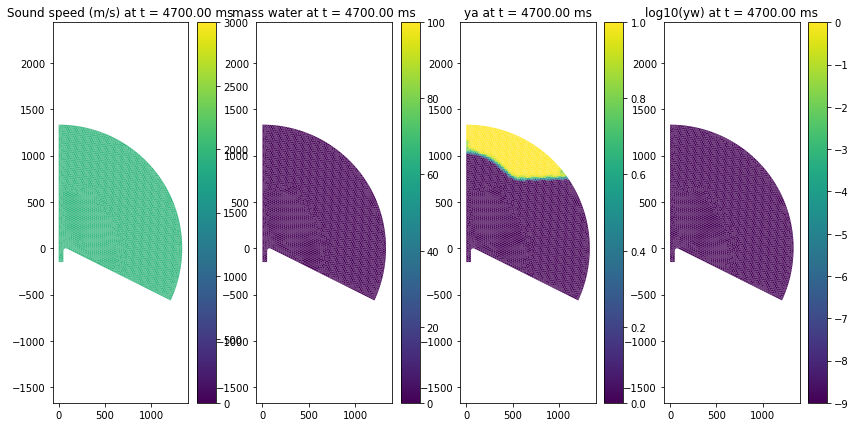

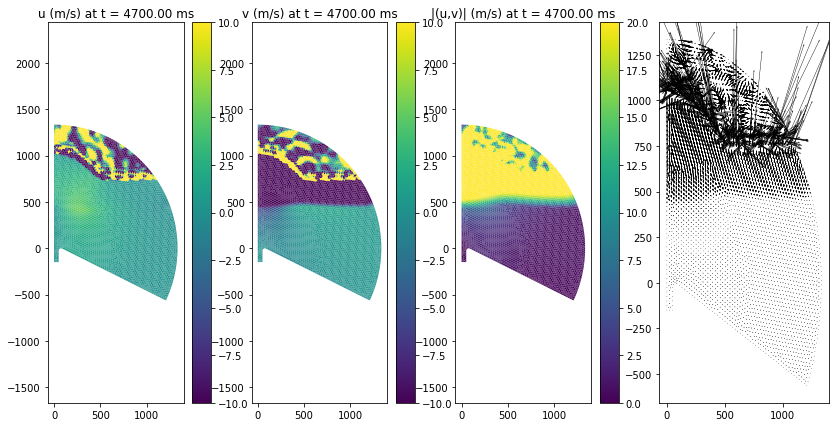

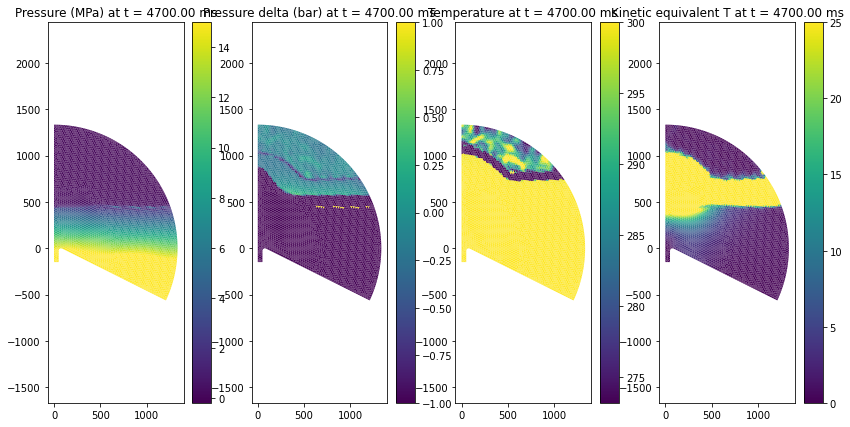

In [19]:
# All plots
plt.figure(figsize=(14,7))
plt.subplot(1,4,1)
clims = (0, 3000)
mdtools.plot_mean(x, c, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"Sound speed (m/s) at t = {1e3*t:.2f} ms")

plt.subplot(1,4,2)
clims = (0, 100)
mdtools.plot_mean(x, rho_mix * yw, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"mass water at t = {1e3*t:.2f} ms")

plt.subplot(1,4,3)
clims = (0, 1)
mdtools.plot_mean(x, ya, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pure water sound speed (m/s) at t = {1e3*t:.2f} ms")
tl = plt.title(f"ya at t = {1e3*t:.2f} ms")

plt.subplot(1,4,4)
clims = (-9, 0)
mdtools.plot_mean(x, np.log10(yw), clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pure water sound speed (m/s) at t = {1e3*t:.2f} ms")
tl = plt.title(f"log10(yw) at t = {1e3*t:.2f} ms")

# plt.subplot(1,4,4)
# clims = (U_E.min(), U_E.max())
# mdtools.plot_mean(x, U_E, clims)
# sm = plt.cm.ScalarMappable(
#   norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
#   cmap=plt.get_cmap())
# cb = plt.colorbar(sm)
# # tl = plt.title(f"Pure water sound speed (m/s) at t = {1e3*t:.2f} ms")
# tl = plt.title(f"Vol en. at t = {1e3*t:.2f} ms")

plt.figure(figsize=(14,7))
# u
plt.subplot(1,4,1)
clims = (-10, 10)
mdtools.plot_mean(x, u, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"u (m/s) at t = {1e3*t:.2f} ms")
# v
plt.subplot(1,4,2)
clims = (-10, 10)
mdtools.plot_mean(x,v, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"v (m/s) at t = {1e3*t:.2f} ms")
# |V|
plt.subplot(1,4,3)
clims = (0, 20)
mdtools.plot_mean(x,velnorm, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"|(u,v)| (m/s) at t = {1e3*t:.2f} ms")
# quiver
plt.subplot(1,4,4)
plt.quiver(x[...,0].ravel(), x[...,1].ravel(), u.ravel(), v.ravel(), scale=1000)

plt.figure(figsize=(14,7))
plt.subplot(1,4,1)
clims = ((p/1e6).min(), 15)
# Pressure
mdtools.plot_mean(x, p/1e6, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"Pressure (MPa) at t = {1e3*t:.2f} ms")
plt.subplot(1,4,2)
clims = (-1, 1)
# Pressure
mdtools.plot_mean(x, (p-p0)/1e5, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"Pressure delta (bar) at t = {1e3*t:.2f} ms")
plt.subplot(1,4,3)
clims = (273.16, 300)
# Pressure
mdtools.plot_mean(x, T, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"Temperature at t = {1e3*t:.2f} ms")
plt.subplot(1,4,4)
kinetic_pseudoT = 0.5 * rho_mix * (u * u + v * v) / (wlma.R / (wlma.gamma_a - 1.0))
clims = (0, 25)
# Pressure
mdtools.plot_mean(x, kinetic_pseudoT, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"Kinetic equivalent T at t = {1e3*t:.2f} ms")

In [32]:
p.max(), T.min()

(26774395.972688675, -1788.2097678508517)

In [35]:
rhoa = p / wlma.R_a / T
va = 1.0 / rhoa
alphaa = ya * va * rho_mix

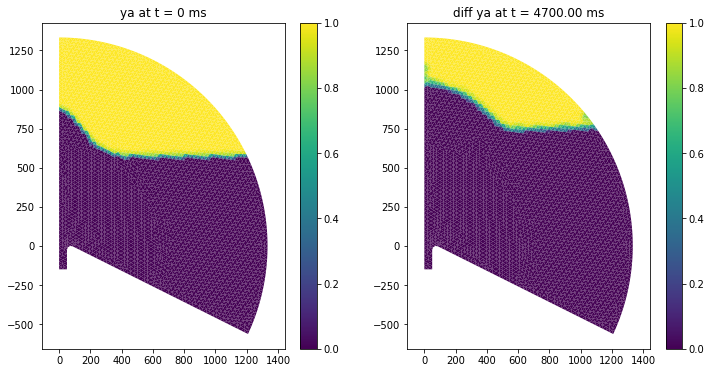

In [27]:
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
clims = (0, 1)
mdtools.plot_mean(x, ya0, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pure water sound speed (m/s) at t = {1e3*t:.2f} ms")
tl = plt.title(f"ya at t = 0 ms")

plt.subplot(1,3,2)
clims = (0, 1)
mdtools.plot_mean(x, ya, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pure water sound speed (m/s) at t = {1e3*t:.2f} ms")
tl = plt.title(f"ya at t = {1e3*t:.2f} ms")

plt.subplot(1,3,3)
clims = (0, 1)
mdtools.plot_mean(x, alphaa, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pure water sound speed (m/s) at t = {1e3*t:.2f} ms")
tl = plt.title(f"volfrac air at t = {1e3*t:.2f} ms")

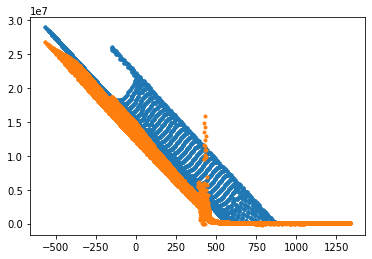

In [31]:
plt.plot(x[...,1:2].ravel(), p0.ravel(), '.')
plt.plot(x[...,1:2].ravel(), p.ravel(), '.')


## Pressure gradients

In [13]:
def get_gradp(solver):
  sample_basis_phys_grad_elems = []
  sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
  for elem_ID in range(solver.mesh.num_elems):
    solver.basis.get_basis_val_grads(
            sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
            get_val=True,
            get_ref_grad=True,
            get_phys_grad=True,
            ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
    sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
  p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
  gradp = np.einsum('ijnl, ink -> ijkl',
      np.array(sample_basis_phys_grad_elems),
      p)
  normgradp = np.linalg.norm(
    gradp,
    axis=-1, keepdims=True)
  return gradp, normgradp

Text(0.5, 1.0, 'Weight |dp/dy|')

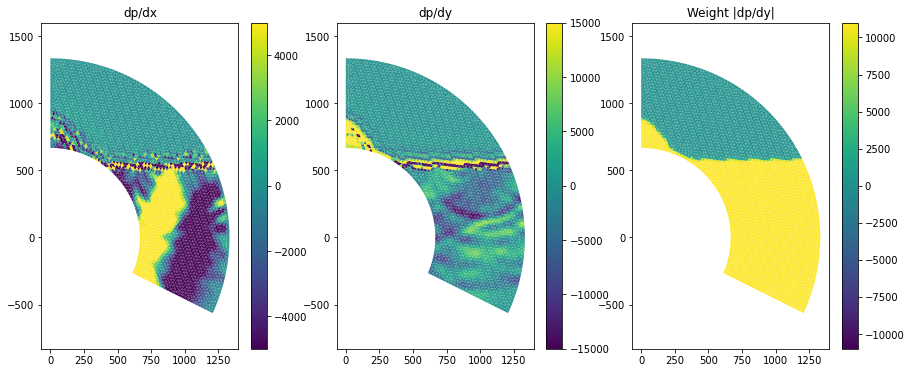

In [14]:
# solver = solver_from_multi(2, 141)
# solver_pg = solver_from_multi(2, 300)
# solver_pg = solver_from_multi(2, 3)
solver_pg = solver
gradp = get_gradp(solver_pg)
_x, _ = mdtools.downsample(solver_pg, plot_qty="Pressure")
_rho = solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)

gradp_rel = gradp[0]
gradp_rel[...,1] += _rho * 9.8
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
clims = (-5000, 5000)
mdtools.plot_mean(_x, gradp_rel[...,0], clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
plt.title("dp/dx")

plt.subplot(1,3,2)
clims = (-15000, 15000)
mdtools.plot_mean(_x, gradp_rel[...,1], clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
plt.title("dp/dy")
clims = (-11000, 11000)
plt.subplot(1,3,3)
mdtools.plot_mean(_x, 9.8 * _rho, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
plt.title("Weight |dp/dy|")

# mdtools.plot_mean(_x, np.linalg.norm(gradp_rel, axis=-1, keepdims=True), (0, 5000))


## Slideshow city

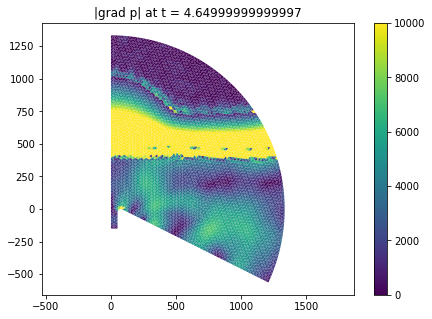

In [21]:
''' Gradient slideshow '''

# solver_from_graphical = lambda domidx, i: readwritedatafiles.read_data_file(
#   f"submarine_proto_WLMA11_atm{domidx}_{i}.pkl")
solver_from_graphical = lambda domidx, i: readwritedatafiles.read_data_file(
  f"lavalake1_atm{domidx}_{i}.pkl")

plt.figure(figsize=(7,5))
for file_idx in range(1,658,25):#range(1,382,20): #range(20):
  plt.clf()
  for domain_idx in [1,2]:
    solver_pg_i = solver_from_graphical(domain_idx, file_idx)
    
    # Compute relative gradient
    gradp = get_gradp(solver_pg_i)
    gradp_rel = gradp[0]
    _rho = solver_pg_i.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
    gradp_rel[...,1] += _rho * 9.8

    # Pressure gradient size
    _x, _ = mdtools.downsample(solver_pg_i, plot_qty="Pressure")

    clims = (0, 1e4)
    mdtools.plot_mean(_x, np.linalg.norm(gradp_rel,axis=-1,keepdims=True), clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  plt.title(f"|grad p| at t = {solver_pg_i.time}")
  plt.savefig(f"volatile3_lavalake_pgrad_frame{file_idx}.png")
  # plt.savefig(f"volatile_pgrad_frame{file_idx}.png")

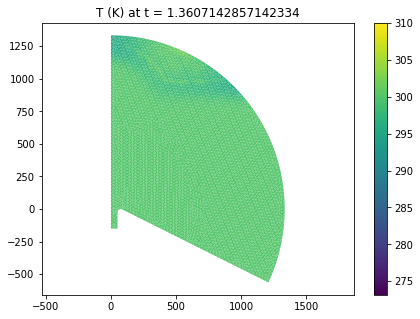

In [100]:
''' Temperature slideshow '''

solver_from_graphical = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA11_atm{domidx}_{i}.pkl")

plt.figure(figsize=(7,5))
for file_idx in range(1,382,20): #range(20):
  plt.clf()
  for domain_idx in [1,2]:
    solver_pg_i = solver_from_graphical(domain_idx, file_idx)
    
    # Compute relative gradient
    # gradp = get_gradp(solver_pg_i)
    # gradp_rel = gradp[0]
    # _rho = solver_pg_i.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
    # gradp_rel[...,1] += _rho * 9.8

    # Pressure gradient size
    _x, _T = mdtools.downsample(solver_pg_i, plot_qty="Temperature")

    clims = (273.16, 310)
    mdtools.plot_mean(_x, _T, clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  plt.title(f"T (K) at t = {solver_pg_i.time}")
  plt.savefig(f"volatile_T_frame{file_idx}.png")

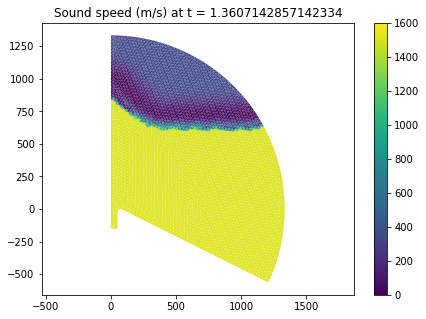

In [101]:
''' Sound speed slideshow '''

solver_from_graphical = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA11_atm{domidx}_{i}.pkl")

plt.figure(figsize=(7,5))
for file_idx in range(1,382,20): #range(20):
  plt.clf()
  for domain_idx in [1,2]:
    solver_pg_i = solver_from_graphical(domain_idx, file_idx)
    
    # Compute relative gradient
    # gradp = get_gradp(solver_pg_i)
    # gradp_rel = gradp[0]
    # _rho = solver_pg_i.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
    # gradp_rel[...,1] += _rho * 9.8

    # Pressure gradient size
    _x, _c = mdtools.downsample(solver_pg_i, plot_qty="SoundSpeed")

    clims = (0.0, 1600)
    mdtools.plot_mean(_x, _c, clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  plt.title(f"Sound speed (m/s) at t = {solver_pg_i.time}")
  plt.savefig(f"volatile_c_frame{file_idx}.png")

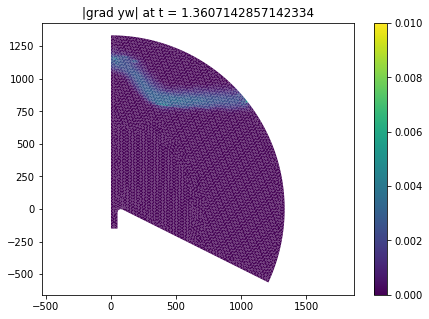

In [161]:
''' Mass fraction gradient slideshow '''

def get_gradyi(solver):
  sample_basis_phys_grad_elems = []
  sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
  for elem_ID in range(solver.mesh.num_elems):
    solver.basis.get_basis_val_grads(
            sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
            get_val=True,
            get_ref_grad=True,
            get_phys_grad=True,
            ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
    sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
  # HACK: get state variables lol
  _U0 = solver.physics.compute_variable("pDensityA", solver.state_coeffs)
  _U1 = solver.physics.compute_variable("pDensityWv", solver.state_coeffs)
  _U2 = solver.physics.compute_variable("pDensityM", solver.state_coeffs)
  _rho = _U0 + _U1 + _U2
  gradval0 = np.einsum('ijnl, ink -> ijkl',
    np.array(sample_basis_phys_grad_elems),
    _U0 / _rho)
  gradval1 = np.einsum('ijnl, ink -> ijkl',
    np.array(sample_basis_phys_grad_elems),
    _U1 / _rho)
  normgradval0 = np.linalg.norm(
    gradval0,
    axis=-1, keepdims=True)
  normgradval1 = np.linalg.norm(
    gradval1,
    axis=-1, keepdims=True)
  return gradval0, normgradval0, gradval1, normgradval1

solver_from_graphical = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA11_atm{domidx}_{i}.pkl")

plt.figure(figsize=(7,5))
for file_idx in range(1,382,20): #range(20): #382
  plt.clf()
  for domain_idx in [1,2]:
    solver_pg_i = solver_from_graphical(domain_idx, file_idx)
    
    # Compute relative gradient
    gradyi = get_gradyi(solver_pg_i)
    gradp_ya = gradyi[2]
    # Pressure gradient size
    _x, _ = mdtools.downsample(solver_pg_i, plot_qty="pDensityA")

    clims = (0, .01)
    mdtools.plot_mean(_x, np.linalg.norm(gradp_ya,axis=-1,keepdims=True), clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  plt.title(f"|grad yw| at t = {solver_pg_i.time}")
  plt.savefig(f"volatile_ywgrad_frame{file_idx}.png")

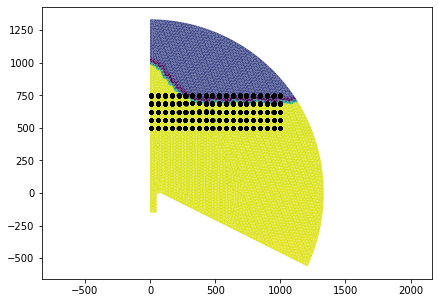

In [147]:
''' Lagrangian trackers at particle velocity '''
# plot.get_numerical_solution(solver.physics, solver.state_coeffs, x,
					# solver.basis, "Pressure")

plt.figure(figsize=(7,5))
# lagrange_points = np.array([[10, 500,1000,1200],[200,500,500,500]])

# Generate Cartesian set of Lagrangian points
_x_sample_range = np.linspace(10, 1000, 20)
_y_sample_range = np.linspace(500, 750, 5)
_x, _y = np.meshgrid(_x_sample_range, _y_sample_range)
_x, _y = _x.ravel(), _y.ravel()
lagrange_points = np.array([_x, _y])


# for file_idx in range(1,382,20): #range(20):

interpolator_u = [None, None]
interpolator_v = [None, None]

# Set background
for domain_idx in [1,2]:
  solver_pg_i = solver_from_graphical(domain_idx, 1)
  _x, _c = mdtools.downsample(solver_pg_i, plot_qty="SoundSpeed")
  clims = (0.0, 1600)
  mdtools.plot_mean(_x, _c, clims)

_stride = 20
_t0 = solver_from_graphical(domain_idx, 1).time
_t1 = solver_from_graphical(domain_idx, 1+_stride).time
_dt = _t1 - _t0

out_idx = 0
for file_idx in range(1,382,_stride):
  for domain_idx in [1,2]:
    solver_pg_i = solver_from_graphical(domain_idx, file_idx)
    interpolator_u[domain_idx-1] = matplotlib.tri.LinearTriInterpolator(
      *plot.triangulate(solver_pg_i.physics,
        *mdtools.downsample(solver_pg_i, plot_qty="XVelocity")))
    interpolator_v[domain_idx-1] = matplotlib.tri.LinearTriInterpolator(
      *plot.triangulate(solver_pg_i.physics,
        *mdtools.downsample(solver_pg_i, plot_qty="YVelocity")))

  # Combine points
  _u = interpolator_u[0](*lagrange_points)
  _u = np.where(_u.mask, interpolator_u[1](*lagrange_points), _u)
  _v = interpolator_v[0](*lagrange_points)
  _v = np.where(_v.mask, interpolator_v[1](*lagrange_points), _v)

  # Add Cartesian markers  
  lagrange_points += _dt * np.array([_u, _v])
  plt.plot(*lagrange_points, 'k.')
  
    # print(interpolator(*seed))
  # var_points
  plt.savefig(f"volatile_lagrangian_frame{out_idx}.png")
  out_idx += 1

In [153]:
_u.min()

-0.3515482222357676

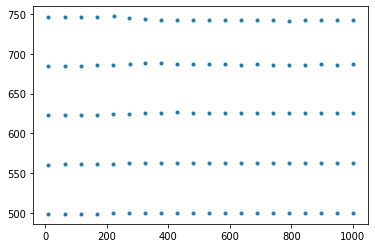

In [148]:
plt.plot(*lagrange_points, '.')

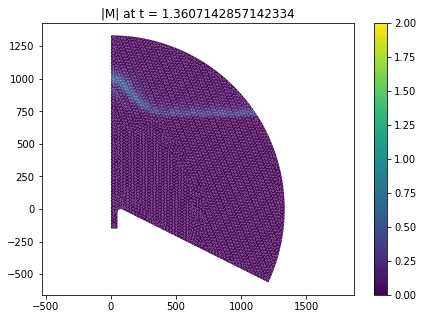

In [102]:
''' Sound speed slideshow '''

solver_from_graphical = lambda domidx, i: readwritedatafiles.read_data_file(
  f"submarine_proto_WLMA11_atm{domidx}_{i}.pkl")

plt.figure(figsize=(7,5))
for file_idx in range(1,382,20): #range(20):
  plt.clf()
  for domain_idx in [1,2]:
    solver_pg_i = solver_from_graphical(domain_idx, file_idx)
    
    # Compute relative gradient
    # gradp = get_gradp(solver_pg_i)
    # gradp_rel = gradp[0]
    # _rho = solver_pg_i.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
    # gradp_rel[...,1] += _rho * 9.8

    # Pressure gradient size
    _x, _u = mdtools.downsample(solver_pg_i, plot_qty="Velocity")
    _x, _c = mdtools.downsample(solver_pg_i, plot_qty="SoundSpeed")

    clims = (0.0, 2.0)
    mdtools.plot_mean(_x, _u/_c, clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  plt.title(f"|M| at t = {solver_pg_i.time}")
  plt.savefig(f"volatile_M_frame{file_idx}.png")

Text(0.5, 1.0, 'Weight |dp/dy|')

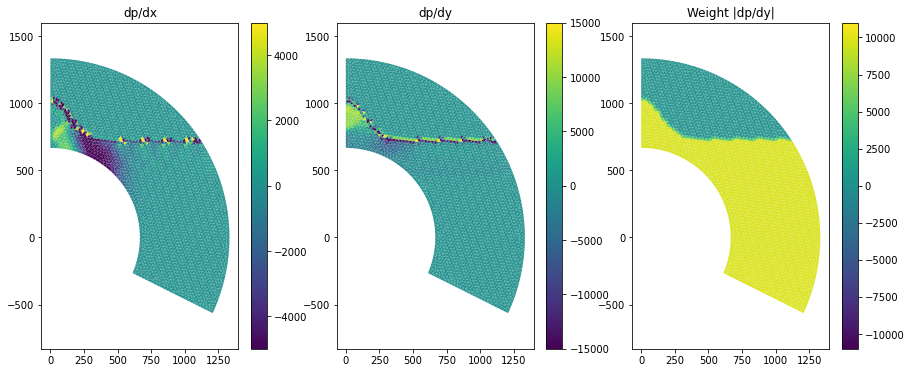

Text(0.5, 1.0, 'Sound speed')

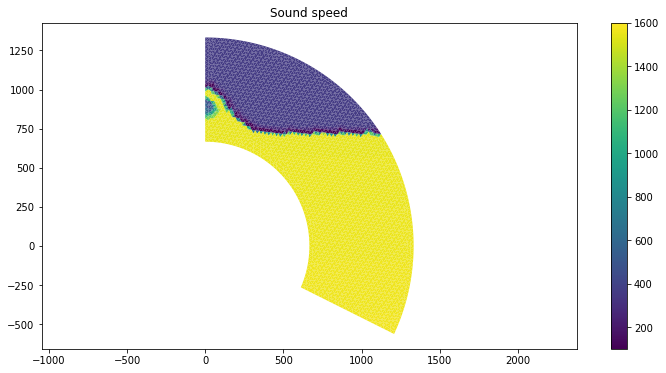

In [87]:
plt.figure(figsize=(12,6))

clims = (100, 1600)
# solver.physics.compute_variable()
_, c = mdtools.downsample(solver_pg, plot_qty="SoundSpeed")

mdtools.plot_mean(_x, c, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
plt.title("Sound speed")


In [166]:
Us = solver_from_multi(2, 300).state_coeffs
Us[...,1].max()
ps = solver.physics.compute_variable("Pressure", Us)
ps.max()

13198879.931232601

In [190]:
dpdx = gradp_rel[...,0]
_indset = np.unravel_index(np.argmax(np.abs(dpdx)), dpdx.shape)
_indelt = _indset[0]
_x[_indset[0],...]

array([[242.2877867689256, 705.5925942954105],
       [227.252993357217 , 686.492271389971 ],
       [251.9425135117497, 683.5387258083939]])

In [191]:
# _indset, Us.shape, Us[_indset,...].shape

((3613, 0, 0), (5079, 3, 9), (3, 3, 9))

In [193]:
solver.physics.compute_variable("Pressure", Us)[_indelt, ...]
solver.physics.compute_variable("SoundSpeed", Us)[_indelt, ...]

array([[ 447.2368374800903],
       [1446.038580423377 ],
       [ 809.097024473273 ]])

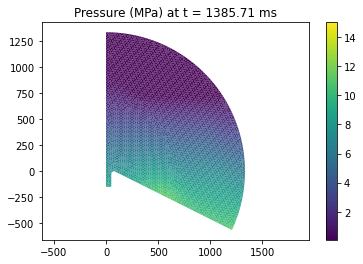

In [159]:
%matplotlib inline
clims = ((p/1e6).min(), 15)
# Pressure
mdtools.plot_mean(x, p/1e6, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"Pressure (MPa) at t = {1e3*t:.2f} ms")

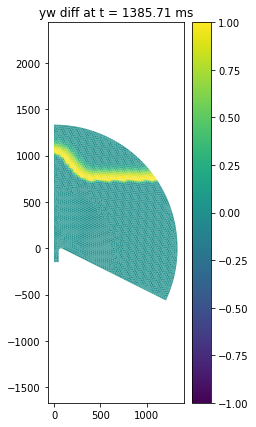

In [160]:
''' Series 2 '''

plt.figure(figsize=(14,7))
plt.subplot(1,4,1)
clims = (-1, 1)
# Pressure
mdtools.plot_mean(x, yw-yw0, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"yw diff at t = {1e3*t:.2f} ms")

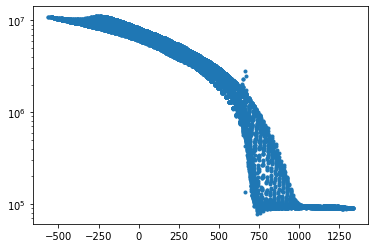

In [161]:
plt.semilogy(x[...,1].ravel(), p.ravel(), '.')

In [13]:
T.min()

251.94549981421923

In [88]:
ya.max()

0.9999998900000104

Dashed: 273.16 K (water triple point)


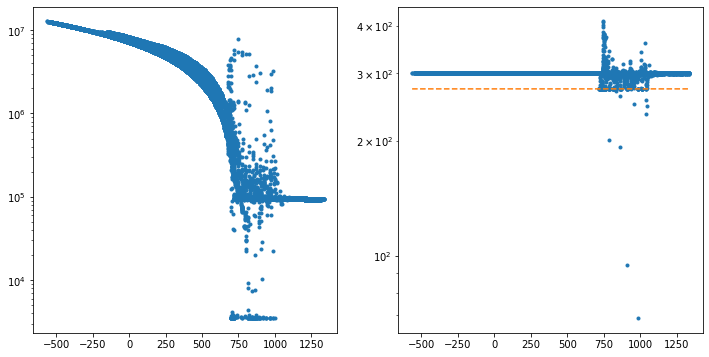

In [74]:
''' Pressure and temperature monitor '''
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.semilogy(x[...,1].ravel(), p.ravel(), '.')
plt.subplot(1,2,2)
plt.semilogy(x[...,1].ravel(), T.ravel(), '.')
plt.semilogy(sorted(x[...,1].ravel()), 273.16*np.ones_like(T.ravel()), '--')
print("Dashed: 273.16 K (water triple point)")
# plt.semilogy(x[...,1].ravel(), T.ravel(), '.')


In [156]:
ya.max()

0.9999998900000612

## File inspection

In [41]:
npzfile = np.load("./debug_dump.npz")
npzfile.files
npzfile["res1"].shape

(5079, 3, 9)

Text(0.5, 1.0, 'Water')

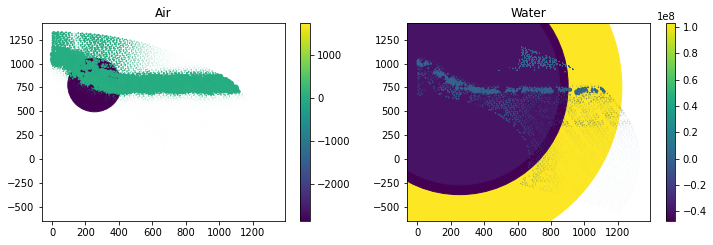

In [55]:
# General residual trace plot
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
_ind = 0
plt.scatter(solver.elem_helpers.x_elems.mean(axis=1, keepdims=True)[...,0:1].ravel(),
            solver.elem_helpers.x_elems.mean(axis=1, keepdims=True)[...,1:2].ravel(),
            s=np.abs(npzfile["res1"][...,_ind:_ind+1].mean(axis=1, keepdims=True).ravel()),
            c=npzfile["res1"][...,_ind:_ind+1].mean(axis=1, keepdims=True).ravel())
plt.colorbar()
plt.title("Air")

plt.subplot(2,2,2)
_ind = 1 # State index
plt.scatter(solver.elem_helpers.x_elems.mean(axis=1, keepdims=True)[...,0:1].ravel(),
            solver.elem_helpers.x_elems.mean(axis=1, keepdims=True)[...,1:2].ravel(),
            s=np.abs(npzfile["res1"][...,_ind:_ind+1].mean(axis=1, keepdims=True).ravel())/1e3,
            c=npzfile["res1"][...,_ind:_ind+1].mean(axis=1, keepdims=True).ravel())
plt.colorbar()
plt.title("Water")

In [63]:
# Find problem element
elt_idx = np.unravel_index(np.argmax(npzfile["res1"][...,_ind].ravel()), npzfile["res1"][...,_ind].shape)[0]
Ustar = npzfile["U0"][elt_idx:elt_idx+1,...]

In [ ]:
Ustar

In [71]:
loggus = mixtureWLMA.SimpleLogger()
solver.physics.wlma.WLM_rhopT_native_serial(Ustar[...,0:3], Ustar[...,3:5], Ustar[...,5:6], loggus)

(array([[[998.9030611419679],
         [999.8588634490968],
         [996.1241544342041]]]),
 array([[[   611.6547710078996],
         [131010.4155231398   ],
         [   611.6547710078996]]]),
 array([[[273.16],
         [273.16],
         [273.16]]]),
 array([[[26.036094603925086],
         [82.06898008091521 ],
         [12.909527709172671]]]),
 array([[[0.999982005910601],
         [0.980941025641397],
         [0.99998310786013 ]]]))

In [73]:
loggus.curr_log

[('info',
  {'stage': 'initialguess',
   'alphaw_candidates': [0.999987235542065,
    1e-05,
    0.01,
    0.5,
    0.99,
    0.99999,
    0.9999847412124634,
    0.9999820059106013],
   'alphaw_candidate_performance': [1.0000000001341969,
    1.9999799306855566,
    1.9800999312802317,
    1.249999965353386,
    1.0001003675382985,
    1.0000000001423106,
    1.0000000001399931,
    1.0000000001606544],
   'alphaw_argmin': 7,
   'T_init': 273.16,
   'is_low_confidence': True}),
 ('info',
  {'stage': 'init',
   'f0': -1.0000000000670517,
   'f1': -5.1527557780595146e-06,
   'U0': 0.9999820059106013,
   'U1': 273.16,
   'step0': -0.28798195180679176,
   'step1': -325976.2720126284,
   'region_type_curr': 1}),
 ('info',
  {'stage': 'bounds',
   'U0': 0.9999820059106013,
   'U1': 273.16,
   'step0': 0.0,
   'step1': 0.0}),
 ('info',
  {'stage': 'backtrack',
   'f0': -1.0000000000670517,
   'f1': -5.1527557780595146e-06,
   'U0': 0.9999820059106013,
   'U1': 273.16,
   'step0': 0.0,
   'st

In [69]:
solver.physics.wlma(Ustar[...,0:3], Ustar[...,3:5], Ustar[...,5:6])

(array([[[998.9030611419679],
         [999.8588634490968],
         [996.1241544342041]]]),
 array([[[   611.6547710078996],
         [131010.4155231398   ],
         [   611.6547710078996]]]),
 array([[[273.16],
         [273.16],
         [273.16]]]),
 array([[[26.036094603925086],
         [82.06898008091521 ],
         [12.909527709172671]]]),
 array([[[0.999982005910601],
         [0.980941025641397],
         [0.99998310786013 ]]]))

In [64]:
# Manipulate problem element state
_y = Ustar[...,0:3] / Ustar[...,0:3].sum(axis=-1,keepdims=True)
solver.physics.compute_variable("Pressure", Ustar)

array([[[   611.6547710078996],
        [131010.4155231398   ],
        [   611.6547710078996]]])

In [67]:
solver.physics.compute_variable("Pressure", npzfile["U0"][elt_idx-1:elt_idx+0,...])


array([[[11609497.027785711],
        [11578201.713022696],
        [11785916.348618971]]])

## Mixture sound speed concoction

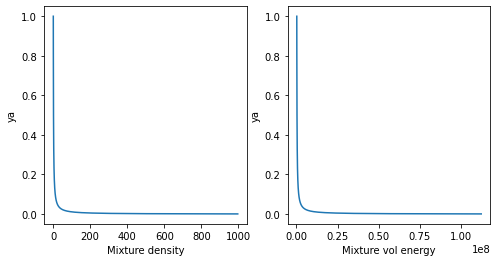

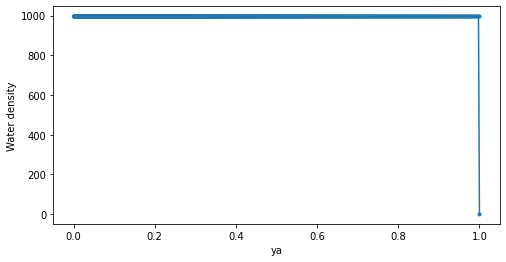

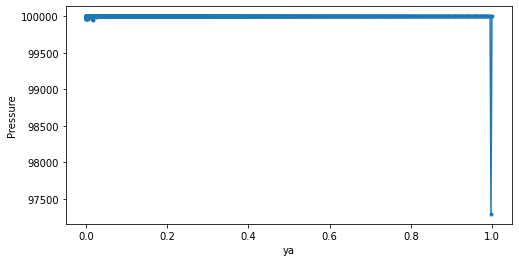

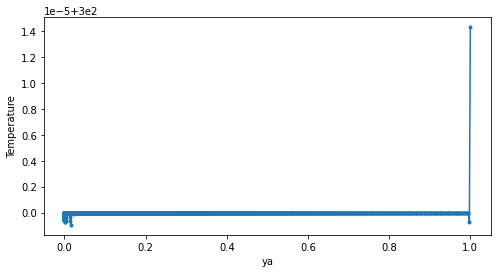

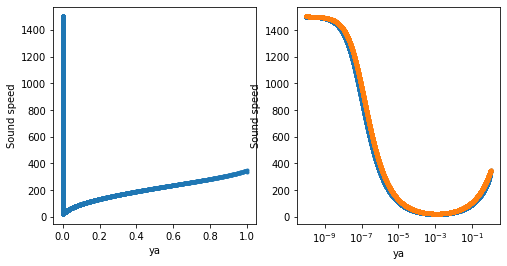

In [258]:
import float_mix_functions

wlma = mixtureWLMA.WLMA()
T_ref = 300
p_ref = 1e5
rhol_ref = float_mix_functions.rho_l_pt(p_ref, T_ref)

ya_vec = np.geomspace(1e-10, 1-1e-10, 10000)
ym = 1e-7
yw_vec = 1 - (ya_vec + ym)

ea = wlma.R_a * T_ref / (wlma.gamma_a - 1.0)
em = wlma.c_v_m0 * T_ref \
  + float_mix_functions.magma_mech_energy(p_ref, wlma.K, wlma.p_m0, wlma.rho_m0)
ew = float_mix_functions.u(rhol_ref, T_ref)
# wlma()

va = wlma.R_a * T_ref / p_ref
rhom = wlma.rho_m0 * (1.0 + (p_ref - wlma.p_m0) / wlma.K)
vm = 1.0 / rhom
vw = 1.0 / rhol_ref

v_mix = ya_vec * va + ym * vm + yw_vec * vw
rho_mix = 1.0 / v_mix
e_mix = rho_mix * (ya_vec * ea + ym * em + yw_vec * ew)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(rho_mix, ya_vec)
plt.xlabel("Mixture density")
plt.ylabel("ya")
plt.subplot(1,2,2)
plt.plot(e_mix, ya_vec)
plt.xlabel("Mixture vol energy")
plt.ylabel("ya")

arhovec_in = np.concatenate((np.reshape(rho_mix * ya_vec, (-1,1,1)),
                             np.reshape(rho_mix * yw_vec, (-1,1,1)),
                             np.reshape(rho_mix * ym, (-1,1,1)),), axis=2)
momentum_in = np.zeros_like(arhovec_in)[...,0:2]
vol_energy_in = np.reshape(e_mix, (-1,1,1))

out_rho, out_p, out_T, out_c, out_alphaw = wlma(
  arhovec_in, momentum_in, vol_energy_in)

plt.figure(figsize=(8,4))
plt.plot(ya_vec, out_rho.ravel(), '.-')
plt.xlabel("ya")
plt.ylabel("Water density")

plt.figure(figsize=(8,4))
plt.plot(ya_vec, out_p.ravel(), '.-')
plt.xlabel("ya")
plt.ylabel("Pressure")

plt.figure(figsize=(8,4))
plt.plot(ya_vec, out_T.ravel(), '.-')
plt.xlabel("ya")
plt.ylabel("Temperature")

plt.figure(figsize=(8,4))
woods_c2 = 1.0 / (rho_mix*rho_mix) / (ya_vec * (va*va) / (np.sqrt(wlma.R_a * wlma.gamma_a * T_ref)**2) \
  + yw_vec / (rhol_ref*rhol_ref) / float_mix_functions.sound_speed(rhol_ref, T_ref)**2
  + ym * (vm*vm) / np.sqrt(wlma.K / wlma.rho_m0)**2)
woods_c = np.sqrt(woods_c2)
plt.subplot(1,2,1)
plt.plot(ya_vec, out_c.ravel(), '.-')
plt.xlabel("ya")
plt.ylabel("Sound speed")
plt.subplot(1,2,2)
plt.semilogx(ya_vec, out_c.ravel(), '.-')
plt.xlabel("ya")
plt.ylabel("Sound speed")
plt.semilogx(ya_vec, woods_c.ravel(), '.-')


Text(0, 0.5, 'Sound speed')

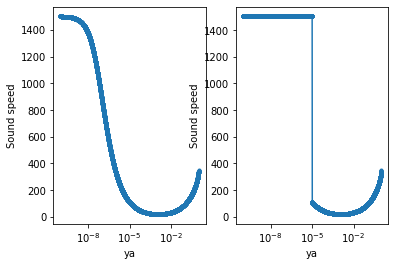

In [278]:
woods_c2 = 1.0 / (rho_mix*rho_mix) / (ya_vec * (va*va) / (np.sqrt(wlma.R_a * wlma.gamma_a * T_ref)**2) \
  + yw_vec / (rhol_ref*rhol_ref) / float_mix_functions.sound_speed(rhol_ref, T_ref)**2
  + ym * (vm*vm) / np.sqrt(wlma.K / wlma.rho_m0)**2)
woods_c = np.sqrt(woods_c2)
arithmetic_c = ya_vec * np.sqrt(wlma.R_a * wlma.gamma_a * T_ref) \
  + yw_vec * float_mix_functions.sound_speed(rhol_ref, T_ref) \
  + ym * np.sqrt(wlma.K / wlma.rho_m0)
plt.subplot(1,2,1)
# plt.plot(ya_vec, out_c.ravel(), '.-')
plt.semilogx(ya_vec, out_c.ravel(), '.-')
plt.xlabel("ya")
plt.ylabel("Sound speed")

# Associate data with clipped sound speeds
clipped_c = out_c.copy()
clipped_c = np.where(np.reshape(ya_vec, out_c.shape) <= 1e-5,
  float_mix_functions.sound_speed(rhol_ref, T_ref), clipped_c)

plt.subplot(1,2,2)
plt.semilogx(ya_vec, clipped_c.ravel(), '.-')
plt.xlabel("ya")
plt.ylabel("Sound speed")
# plt.semilogx(ya_vec, ya_vec * out_c.ravel() + yw_vec * arithmetic_c.ravel(), '.-')
# plt.semilogx(ya_vec, arithmetic_c.ravel(), '.-')

In [233]:
loc_logger = mixtureWLMA.SimpleLogger()
wlma.WLM_rhopT_native_serial(arhovec_in[0:1,...], momentum_in[0:1,...], vol_energy_in[0:1,...], loc_logger)



(array([[[791.7071874009729]]]),
 array([[[3535.651010453852]]]),
 array([[[299.99444017737073]]]),
 array([[[4.655787805026473]]]),
 array([[[0.999807214113915]]]))

In [237]:
loc_logger.curr_log
rhol_ref

996.5563403888918

In [240]:
arhovec_in[0:1,...]# 0.999807214113915
rho_mix
yw_vec * vw

array([ 1.003455449001272e-03,  1.003355093411782e-03,
        1.003254737822292e-03, ...,  2.006208679801011e-07,
        1.002652784898743e-07, -9.031100024108583e-11])

In [245]:
ym , vm

(1e-07, 2598.726)

In [242]:
(ya_vec * va + ym * vm + yw_vec * vw)[0,...], (yw_vec * vw)[0,...]

(array(0.001263336659001), array(0.001003455449001))

### Animation

In [56]:
%matplotlib tk
mdtools.generate_anim(
  ["submarine_proto_WLMA11_atm1", "submarine_proto_WLMA11_atm2"],
  [],
  "volatile_submarine_proto_WLMA11",
  20,
  "Pressure",
  filter=lambda x, x0: x - x0,
  initial=0, stride=7, clims=(-1e5, 1e5))
# mdtools.generate_anim(
#   ["submarine_proto_WLMA10_atm1", "submarine_proto_WLMA10_atm2"],
#   [],
#   "volatile_velocity_submarine_proto_WLMA10",
#   24,
#   "Velocity",
#   filter=lambda x, x0: x,
#   initial=0, stride=20, clims=(0, 100))
mdtools.generate_anim(
  ["submarine_proto_WLMA11_atm1", "submarine_proto_WLMA11_atm2"],
  [],
  "volatile_velnorm_submarine_proto_WLMA11",
  20,
  "Velocity",
  filter=lambda x, x0: x,
  initial=0, stride=7, clims=(0, 100))

Animation constructed
Animation constructed


In [ ]:
# plt.quiver(x[...,0].ravel(), x[...,1].ravel(), u.ravel(), v.ravel(), scale=1000)
#TODO: check p < 1e4 is consistent with the conservattive vars

In [79]:
# Compute minimum mesh edge length
def min_edge_length_in(solver):
  pairwise_dists = scipy.spatial.distance.cdist(
      solver.mesh.node_coords,
      solver.mesh.node_coords) \
    + np.diag(np.inf * np.ones((solver.mesh.node_coords.shape[0],)))
  return pairwise_dists.min()
# Minimum edge length in each domain
[min_edge_length_in(solver_from_multi(dom_idx, 0)) for dom_idx in domain_read_list]

[6.206079489753531, 48.40290933048376]

In [36]:
# Check global mass fraction diffusion / decay
ya.max()

0.9999998900002796

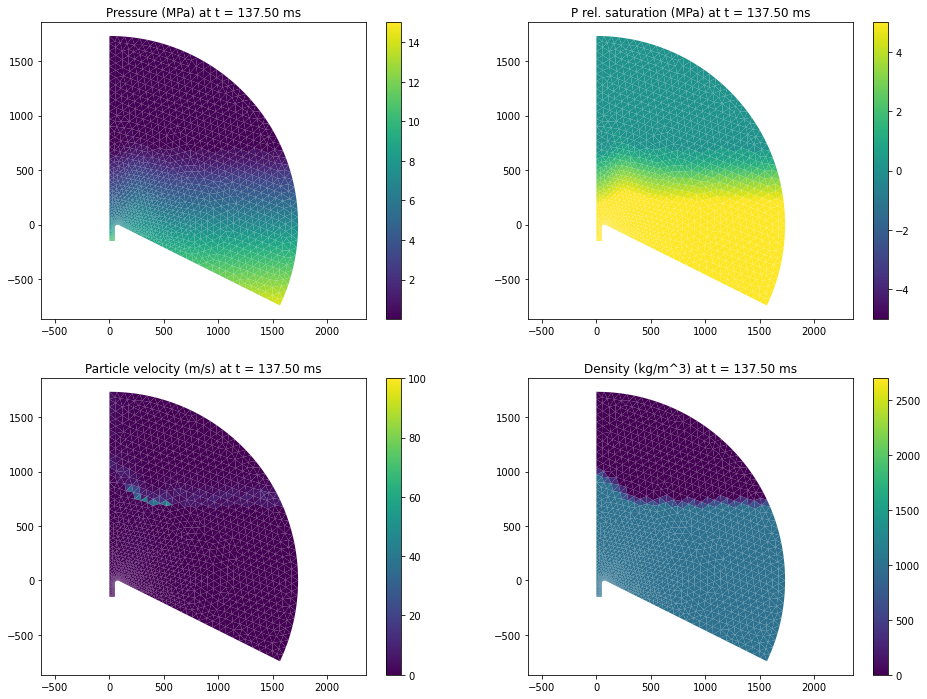

In [38]:
# Plot pressure, mixture states
# clims = (0, 22.06e6)
%matplotlib inline
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
clims = (0, 100)
clims = ((p/1e6).min(), (p/1e6).max())
clims = ((p/1e6).min(), 15)

mdtools.plot_mean(x, p/1e6, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"Pressure (MPa) at t = {1e3*t:.2f} ms")

plt.subplot(2,2,2)
clims = (-5, 5)
mdtools.plot_mean(x, (p - psats)/1e6, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"P rel. saturation (MPa) at t = {1e3*t:.2f} ms")

plt.subplot(2,2,3)
clims = (0, 100)
mdtools.plot_mean(x, velnorm, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"Particle velocity (m/s) at t = {1e3*t:.2f} ms")

plt.subplot(2,2,4)
clims = (0, 2700)
mdtools.plot_mean(x, rho_mix, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"Density (kg/m^3) at t = {1e3*t:.2f} ms")

## Solution inspection

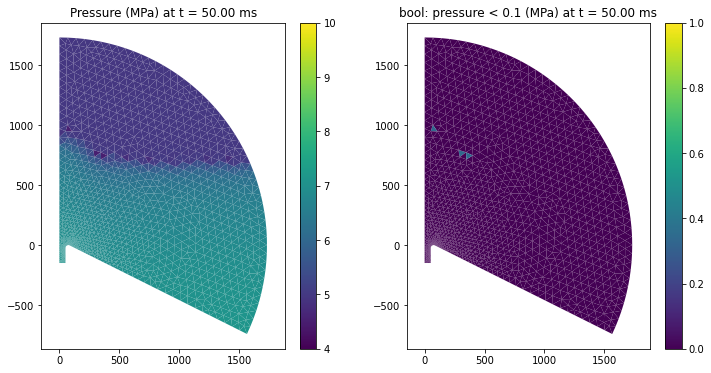

In [24]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
clims = (4, 10)
mdtools.plot_mean(x, np.log10(p), clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"Pressure (MPa) at t = {1e3*t:.2f} ms")

plt.subplot(1,2,2)
clims = (0, 1)
mdtools.plot_mean(x, np.log10(p) < 4, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"bool: pressure < 0.1 (MPa) at t = {1e3*t:.2f} ms")

In [11]:
# plt.plot((np.log10(p) < 4).ravel().astype(float),'.')

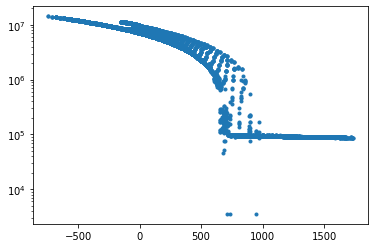

In [27]:
plt.semilogy(x[...,1].ravel(), p.ravel(), '.')

In [20]:
class SimpleLogger():
  def __init__(self):
    self.curr_log = []
    self.all_logs = [self.curr_log]
  def log(self, level, data):
    self.curr_log.append((level, data))
  def create_new_log(self):
    self.curr_log = []
    self.all_logs.append(self.curr_log)
  def pop_log(self):
    return self.all_logs.pop()

In [21]:
# Check out why pressure < 1e4 appears
logger_inspect = SimpleLogger()
# _out = wlma.WLM_rhopT_native_serial(
#     solver.state_coeffs[...,0:3],
#     solver.state_coeffs[...,3:5],
#     solver.state_coeffs[...,5:6], logger=logger_inspect)
# x, rho_mix, ya, yw, ym, u, v, steamfrac, rhow, p, T, psats, U_E, c, alphaw, aux
_out = wlma.WLM_rhopT_native_serial(
    rho_mix * np.concatenate((ya, yw, ym), axis=2),
    np.concatenate((u, v), axis=2),
    U_E, logger=logger_inspect)

In [22]:
_out[1].min(), p.min()

(3535.9342508742916, 3535.9310722559208)

In [28]:
# Visualize logs with pandas
import pandas as pd
_log_dat = pd.DataFrame(logger_inspect.curr_log)
_log_dat
logs_df = pd.concat(
  [_log_dat[0], pd.json_normalize(_log_dat[1])], axis=1).rename(
  columns={0:"level"})
# logs_df

In [26]:
# Filter where pressure anomalously low
prob_elt_index = np.where(np.any(_out[1] < 1e4,axis=1).ravel())
prob_elt_index_flat = np.where(_out[1].ravel() < 1e4)
_kinetic = 0.5 * rho_mix * (u * u + v * v)
# Reduce to problematic indices
_rho_mix, _ya, _yw, _ym, _kinetic, _vol_energy_total, _T, _p_check = \
  (ndarr.ravel()[prob_elt_index_flat] for ndarr in
   (rho_mix, ya, yw, ym, _kinetic, U_E, T, p))
_yw, _ya, _p_check, _vol_energy_total, _rho_mix, _T
# 
_rho_mix, _vol_energy_total, _kinetic

from types import SimpleNamespace
test_vec = SimpleNamespace(**{
  "rho_vec": np.array([[_ya * _rho_mix], [_yw * _rho_mix], [_ym * _rho_mix]]).T,
  "momentum": np.array([[0.0*_rho_mix], [0.0*_rho_mix]]).T,
  "vol_energy": np.array([[_vol_energy_total - _kinetic]]).T})

logger_focus = SimpleLogger()
_out = wlma.WLM_rhopT_native_serial(
    test_vec.rho_vec,
    test_vec.momentum,
    test_vec.vol_energy,
    logger=logger_focus)
logger_focus.curr_log

[('info',
  {'stage': 'initialguess',
   'alphaw_candidates': [0.9997579852313934,
    1e-05,
    0.01,
    0.5,
    0.99,
    0.99999,
    0.999755859399414,
    0.9997632872240264],
   'alphaw_candidate_performance': [6.710269018397351e-09,
    1.1062761220814807,
    1.0863961226822432,
    0.356296157053971,
    0.0003224247181404094,
    6.059665807997661e-08,
    6.714279467626685e-09,
    6.7396489240246305e-09],
   'alphaw_argmin': 0,
   'T_init': 300.02392673445485,
   'is_low_confidence': False}),
 ('info',
  {'stage': 'init',
   'f0': 8.191619587760712e-05,
   'f1': 7.66246621708433e-08,
   'U0': 0.9997579852313934,
   'U1': 300.02392673445485,
   'step0': -1.0624358159337364e-07,
   'step1': -0.002207203790972845,
   'region_type_curr': 1}),
 ('info',
  {'stage': 'bounds',
   'U0': 0.9997578789878118,
   'U1': 300.02171953066386,
   'step0': -1.0624358159337364e-07,
   'step1': -0.002207203790972845}),
 ('info',
  {'stage': 'backtrack',
   'f0': -7.128408974210743e-12,
   '

In [57]:
''' Garbage collection '''
np.where(np.all(_out[1] < 5e4,axis=1).ravel())
# solver.state_coeffs[prob_elt_index,...,0:3] / solver.state_coeffs[prob_elt_index,...,0:3].sum(axis=-1,keepdims=True)
prob_elt_index_flat = np.where(_out[1].ravel() < 3e4)
# _yw = solver.state_coeffs[...,0:1] / solver.state_coeffs[...,0:3].sum(axis=-1,keepdims=True)
yw.ravel()[prob_elt_index_flat]
solver.state_coeffs[...,0:3].sum(axis=-1,keepdims=True)
solver.state_coeffs[prob_elt_index,...,0:3] / solver.state_coeffs[prob_elt_index,...,0:3].sum(axis=-1,keepdims=True)
ya.shape, (0.5 * rho_mix * (u * u + v * v)).shape, U_E


array([4.959469787817659e-07, 3.911194458862901e-07,
       1.149605271873438e-08, 7.606857902394519e-07,
       3.918323423107062e-08, 3.628696565543376e-07,
       6.535254734043889e-08, 7.162571316928475e-08,
       7.563666867939589e-08, 1.755753076791300e-08,
       6.816517624802913e-07, 4.033822556421200e-07,
       1.327080366478983e-07, 3.106703341202093e-08,
       8.588487388980634e-08, 1.210481525338455e-07,
       5.214323743114333e-07, 1.062823211293675e-08,
       2.694742046681036e-07, 4.212099798625198e-07,
       1.010107233521180e-08, 7.711428178648381e-07,
       1.031283662559293e-08, 3.882278618241377e-08,
       4.897944384112876e-08, 6.611631600465162e-07,
       1.017738841391281e-08, 2.009105565120530e-08,
       1.083813556754555e-08, 1.017322418927196e-08,
       2.334653563916504e-07, 9.538051744733198e-08,
       7.847236547236706e-07, 9.950318902564253e-08,
       3.188576089766799e-08, 5.183640344060868e-07,
       4.930419455444726e-07, 1.40121138915543

In [43]:
''' Check anomalously high pressures '''
prob_elt_index_flat = np.where(_out[1].ravel() > 1e9)
_kinetic = 0.5 * rho_mix * (u * u + v * v)
# Reduce to problematic indices
_rho_mix, _ya, _yw, _ym, _kinetic, _vol_energy_total, _T, _p_check = \
  (ndarr.ravel()[prob_elt_index_flat] for ndarr in
   (rho_mix, ya, yw, ym, _kinetic, U_E, T, p))
_yw, _ya, _p_check, _vol_energy_total, _rho_mix, _T
# 
_rho_mix, _vol_energy_total, _kinetic

(array([1.123071852948867, 1.123679833813856, 1.123635006613957,
        1.12352426060013 , 1.118001882151746, 1.127786591213848,
        1.131256229083164, 1.126329649661358, 1.126892161233924,
        1.125504731543659, 1.125522706174051, 1.124518496290991,
        1.122622118210833, 1.123491085301263, 1.126175937944457,
        1.120272242016815, 1.119264129872939, 1.131374190149638,
        1.120170343870849]),
 array([124547.38580211431, 113975.60663312723, 121823.70347950877,
         94863.48270521339, 138206.82068716595, 100752.46569781864,
        122028.0116523753 , 106843.8191799445 , 128829.77454878362,
         97895.00281611121, 106011.01716307357, 123278.3909116696 ,
        110640.0830823477 ,  96396.39631035582, 104085.91903227627,
         91358.25112975485,  90199.7182554217 , 110214.09625649727,
         94343.63957904428]),
 array([ 46.882323785845216,  61.58380425791318 ,  26.40033176014182 ,
         73.40478563247135 ,  47.35051467156502 ,  89.39546103177584 ,
 

In [50]:
np.array([[_ya * _rho_mix], [_yw * _rho_mix], [_ym * _rho_mix]]).T.shape, np.array([[0.0*_rho_mix, 0.0*_rho_mix]]).T.shape

((19, 1, 3), (19, 2, 1))

In [54]:
from types import SimpleNamespace
test_vec = SimpleNamespace(**{
  "rho_vec": np.array([[_ya * _rho_mix], [_yw * _rho_mix], [_ym * _rho_mix]]).T,
  "momentum": np.array([[0.0*_rho_mix], [0.0*_rho_mix]]).T,
  "vol_energy": np.array([[_vol_energy_total - _kinetic]]).T})

logger_focus = SimpleLogger()
_out = wlma.WLM_rhopT_native_serial(
    np.array([[_ya * _rho_mix], [_yw * _rho_mix], [_ym * _rho_mix]]).T,
    np.array([[0.0*_rho_mix], [0.0*_rho_mix]]).T,
    np.array([[_vol_energy_total - _kinetic]]).T, logger=logger_focus)
logger_focus.curr_log

[('info',
  {'stage': 'dryapprox',
   'yw': 1.373521641508153e-08,
   'T_approx': 202679000125.8155,
   'p_approx': 65327818037451.24}),
 ('info',
  {'stage': 'dryapprox',
   'yw': 1.1408178589487258e-08,
   'T_approx': 13522356716252.777,
   'p_approx': 4360907064348321.0}),
 ('info',
  {'stage': 'dryapprox',
   'yw': 1.2614856336023318e-08,
   'T_approx': 561255358574.8982,
   'p_approx': 180995433661086.72}),
 ('info',
  {'stage': 'dryapprox',
   'yw': 1.3176860485811938e-08,
   'T_approx': 1.2657958905263499e+17,
   'p_approx': 4.081576989512256e+19}),
 ('info',
  {'stage': 'dryapprox',
   'yw': 1.1264592301434011e-08,
   'T_approx': 787627407.1420946,
   'p_approx': 252723257537.876}),
 ('info',
  {'stage': 'dryapprox',
   'yw': 1.2208863713179487e-08,
   'T_approx': 7579951972061371.0,
   'p_approx': 2.4534388451612365e+18}),
 ('info',
  {'stage': 'dryapprox',
   'yw': 9.999999993944267e-09,
   'T_approx': 601633344037.0347,
   'p_approx': 195332602989462.66}),
 ('info',
  {'stag

In [39]:
logger_focus = SimpleLogger()
_out = wlma.WLM_rhopT_native_serial(
    solver.state_coeffs[prob_elt_index,...,0:3],
    solver.state_coeffs[prob_elt_index,...,3:5],
    solver.state_coeffs[prob_elt_index,...,5:6], logger=logger_focus)

IndexError: index 3779 is out of bounds for axis 0 with size 1090

In [37]:
# _rho_mix = solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
# _ya = solver.state_coeffs[...,0:1] / _rho_mix
# _yw = solver.state_coeffs[...,1:2] / _rho_mix
# _ym = solver.state_coeffs[...,2:3] / _rho_mix
# _kinetic = 0.5 * np.sum(solver.state_coeffs[...,3:5] * solver.state_coeffs[...,3:5], axis=-1, keepdims=True) / _rho_mix
# _vol_energy_total = solver.state_coeffs[...,5:6]

prob_elt_index_flat = np.where(_out[1].ravel() < 3e4)

_kinetic = 0.5 * rho_mix * (u * u + v * v)
# Reduce to problematic indices
_rho_mix, _ya, _yw, _ym, _kinetic, _vol_energy_total, _T, _p_check = \
  (ndarr.ravel()[prob_elt_index_flat] for ndarr in
   (rho_mix, ya, yw, ym, _kinetic, U_E, T, p))
_yw, _ya, _p_check, _vol_energy_total, _rho_mix, _T

(array([0.99999989000016 , 0.999999799230197, 0.999999800899895,
        0.999999801564759, 0.999999754356421, 0.999999890000156,
        0.999999879652846, 0.999999813099223, 0.999999809672685,
        0.999999809140171, 0.999999840172978, 0.99999989000002 ,
        0.999996848762425, 0.999999794358783]),
 array([9.999999900104131e-09, 1.007698024934361e-07,
        9.910010431910031e-08, 9.843524594234914e-08,
        1.456435858198613e-07, 9.999999900112381e-09,
        2.034716624098749e-08, 8.690077724363532e-08,
        9.032731967271959e-08, 9.085983038480924e-08,
        5.982702070659282e-08, 9.999999952499954e-09,
        3.051237575435902e-06, 1.056412357724912e-07]),
 array([ 3583.090151575904, 15295.765978443476, 14241.596131579308,
        11423.820354127136, 17243.855813573355,  3575.828022148878,
        10748.736226785779, 26270.26851597829 , 29498.653321567315,
        21364.814050462526, 18826.29985550828 ,  5020.531927662484,
        20965.49357478045 , 23923.374773

In [127]:
(_vol_energy_total - _kinetic).shape

(1090, 3, 11)

In [132]:
import float_mix_functions
float_mix_functions.vec_conservative_to_pT_WLMA(_vol_energy_total - _kinetic,
                                                _rho_mix, _yw, _ya,
                                                wlma.K, wlma.p_m0, wlma.rho_m0,
                                                wlma.c_v_m0, wlma.R_a,
                                                wlma.gamma_a,
                                                logger=False)[1::4]

array([   88341.58270776812,    90710.14991863894,    89877.61163882687,
        7008772.069518793  ,  9505526.043307029  , 10151309.563058015  ,
          93673.81279628593,    97172.56215996544,    92172.03712583597,
          95209.58753660835,    92853.75908592275])

In [133]:
_out[1].ravel()[prob_elt_index]

array([   88341.58271198091,    90710.1499252411 ,    89877.61163882687,
        7008772.069518793  ,  9505526.043307029  , 10151309.563037647  ,
          93673.8127883815 ,    97172.56217965388,    92172.03713732549,
          95209.58753660835,    92853.75907876872])

In [92]:
logger_focus = SimpleLogger()
_out = wlma.WLM_rhopT_native_serial(
    solver.state_coeffs[prob_elt_index,...,0:3],
    solver.state_coeffs[prob_elt_index,...,3:5],
    solver.state_coeffs[prob_elt_index,...,5:6], logger=logger_focus)
_log_dat = pd.DataFrame(logger_focus.curr_log)
logs_df = pd.concat(
  [_log_dat[0], pd.json_normalize(_log_dat[1])], axis=1).rename(
  columns={0:"level"})
logs_df

,level,stage,alphaw_candidates,alphaw_candidate_performance,alphaw_argmin,T_init,is_low_confidence,f0,f1,U0,...,step0,step1,region_type_curr,fnorm,freq,region_type,squarestepsize,rhow,p,T
0,info,initialguess,"[1.1231388206653066e-13, 1e-05, 0.01, 0.5, 0.9...","[0.9754890865205108, 3866989629.5013943, 38671...",7.0,300.014499,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,info,init,NaN,NaN,NaN,NaN,NaN,4.440892e-16,0.046646,1.127028e-13,...,-2.090790e-19,-8.779616e-14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,info,bounds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e-09,...,9.998873e-10,-0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,info,backtrack,NaN,NaN,NaN,NaN,NaN,2.435185e-10,26.319710,1.000000e-09,...,9.998873e-10,-0.000000e+00,NaN,26.319710,0.041981,1.0,NaN,NaN,NaN,NaN
4,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.997746e-19,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,info,init,NaN,NaN,NaN,NaN,NaN,-4.107825e-15,0.001067,3.389541e-06,...,-1.580296e-13,3.479262e-08,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278,info,bounds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.389541e-06,...,-1.580296e-13,3.479262e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279,info,backtrack,NaN,NaN,NaN,NaN,NaN,-1.110223e-16,0.000001,3.389541e-06,...,-1.580296e-13,3.479262e-08,NaN,0.000001,0.000961,0.0,NaN,NaN,NaN,NaN
280,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.210526e-15,NaN,NaN,NaN


In [95]:
logs_df["stage"].to_numpy()

array(['initialguess', 'init', 'bounds', 'backtrack', 'steptoosmall',
       'finalize', 'initialguess', 'init', 'bounds', 'backtrack', 'init',
       'bounds', 'backtrack', 'steptoosmall', 'finalize', 'initialguess',
       'init', 'bounds', 'backtrack', 'init', 'bounds', 'backtrack',
       'steptoosmall', 'finalize', 'initialguess', 'init', 'bounds',
       'backtrack', 'init', 'bounds', 'backtrack', 'steptoosmall',
       'finalize', 'initialguess', 'init', 'bounds', 'backtrack', 'init',
       'bounds', 'backtrack', 'steptoosmall', 'finalize', 'initialguess',
       'init', 'bounds', 'backtrack', 'steptoosmall', 'finalize',
       'initialguess', 'init', 'bounds', 'backtrack', 'init', 'bounds',
       'backtrack', 'init', 'bounds', 'backtrack', 'steptoosmall',
       'finalize', 'initialguess', 'init', 'bounds', 'backtrack', 'init',
       'bounds', 'backtrack', 'steptoosmall', 'finalize', 'initialguess',
       'init', 'bounds', 'backtrack', 'steptoosmall', 'finalize',
       'in

In [77]:
logs_df.loc[logs_df["level"]=="warning"]

,level,stage,alphaw_candidates,alphaw_candidate_performance,alphaw_argmin,T_init,is_low_confidence,f0,f1,U0,...,step0,step1,region_type_curr,fnorm,freq,region_type,rhow,p,T,squarestepsize
58,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.475667e-19
67,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.512411e-13
76,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.649320e-14
181,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.373082e-15
190,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.049609e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25599,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.132320e-15
25605,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.720578e-13
25635,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.852715e-13
25644,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.798181e-15


In [31]:
%matplotlib tk
plt.quiver(x[...,0].ravel(), x[...,1].ravel(), u.ravel(), v.ravel())

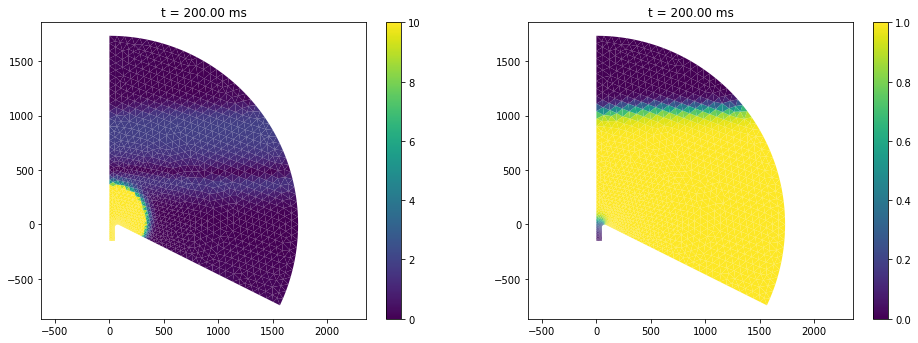

In [78]:
%matplotlib inline
plt.figure(figsize=(16,12))

# Vars:
#   x, rho_mix, ya, yw, ym, u, v, steamfrac, rhow, p, T, psats, U_E

plt.subplot(2,2,1)
# clims = (-.1, .1)
# mdtools.plot_mean(x, v, clims)
clims = (0, 10)
mdtools.plot_mean(x, velnorm, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"t = {1e3*t:.2f} ms")

plt.subplot(2,2,2)
clims = (0, 1)
mdtools.plot_mean(x, yw, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"t = {1e3*t:.2f} ms")

## Lava lake

## Tuning
Using U from the compressible flow code as inputs, we can test which set of iteration parameters are the computational bottleneck.

In [8]:
class SimpleLogger():
  def __init__(self):
    self.curr_log = []
    self.all_logs = [self.curr_log]
  def log(self, level, data):
    self.curr_log.append((level, data))
  def create_new_log(self):
    self.curr_log = []
    self.all_logs.append(self.curr_log)
  def pop_log(self):
    return self.all_logs.pop()

In [18]:
# Reconstruct inputs
arho_vec = rho_mix * np.concatenate((ya, yw, ym,), axis=-1)
momentum = rho_mix * np.concatenate((u, v,), axis=-1)
vol_energy = U_E
# Run with logging
logger = SimpleLogger()
rhow, p, T, _, _ = wlma.WLM_rhopT_native_serial(
    arho_vec, momentum, vol_energy, logger=logger)

In [21]:
# Visualize logs with paPandas
import pandas as pd
_log_dat = pd.DataFrame(logger.curr_log)
logs_df = pd.concat([_log_dat[0], pd.json_normalize(_log_dat[1])], axis=1)
# _log_df = pd.json_normalize(_log_dat[1])
# _log_df.level = _log_dat[0]
logs_df.rename(columns={0:"level"})
# _log_dat = _log_dat[1].apply(pd.Series)

,level,stage,alphaw_candidates,alphaw_candidate_performance,alphaw_argmin,T_init,is_low_confidence,f0,f1,U0,...,step0,step1,region_type_curr,fnorm,freq,region_type,rhow,p,T,squarestepsize
0,info,initialguess,"[0.9980016071347074, 1e-05, 0.01, 0.5, 0.99, 0...","[3.565932812972814e-05, 1.1066926129543044, 1....",5.0,299.909271,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,info,init,NaN,NaN,NaN,NaN,NaN,-2.379990e-03,9.266309e-06,0.999990,...,-8.918248e-06,6.519697e-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,info,bounds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999981,...,-8.918248e-06,6.519697e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,info,backtrack,NaN,NaN,NaN,NaN,NaN,-1.500477e-07,5.941533e-09,0.999981,...,-8.918248e-06,6.519697e-02,NaN,1.501653e-07,0.002142,0.0,NaN,NaN,NaN,NaN
4,info,init,NaN,NaN,NaN,NaN,NaN,-1.500477e-07,5.941533e-09,0.999981,...,-5.852895e-09,4.346575e-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71491,info,init,NaN,NaN,NaN,NaN,NaN,-1.953993e-14,2.424070e-05,0.000313,...,-3.142058e-13,2.785541e-08,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71492,info,bounds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000313,...,-3.142058e-13,2.785541e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71493,info,backtrack,NaN,NaN,NaN,NaN,NaN,6.661338e-15,7.169294e-10,0.000313,...,-3.142058e-13,2.785541e-08,NaN,7.169294e-10,0.000022,0.0,NaN,NaN,NaN,NaN
71494,warning,steptoosmall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.759239e-16


In [24]:
init_guesses = logs_df[logs_df["stage"] == "initialguess"].dropna(axis=1)
init_guesses

,0,stage,alphaw_candidates,alphaw_candidate_performance,alphaw_argmin,T_init,is_low_confidence
0,info,initialguess,"[0.9980016071347074, 1e-05, 0.01, 0.5, 0.99, 0...","[3.565932812972814e-05, 1.1066926129543044, 1....",5.0,299.909271,False
8,info,initialguess,"[0.9980016071347074, 1e-05, 0.01, 0.5, 0.99, 0...","[3.565932812972814e-05, 1.1066926129543044, 1....",5.0,299.909271,False
16,info,initialguess,"[0.9980016071347074, 1e-05, 0.01, 0.5, 0.99, 0...","[3.565932812972814e-05, 1.1066926129543044, 1....",5.0,299.909271,False
24,info,initialguess,"[0.16902154425839386, 1e-05, 0.01, 0.5, 0.99, ...","[0.26121950001481514, 0.5858414208239404, 0.57...",6.0,1045.717770,False
32,info,initialguess,"[0.16902154425839386, 1e-05, 0.01, 0.5, 0.99, ...","[0.26121950001481514, 0.5858414208239404, 0.57...",6.0,1045.717770,False
...,...,...,...,...,...,...,...
71444,info,initialguess,"[0.75, 1e-05, 0.01, 0.5, 0.99, 0.99999, 0.9999...","[0.16969279599481907, 1.1071727442884778, 1.08...",7.0,299.778704,False
71452,info,initialguess,"[0.75, 1e-05, 0.01, 0.5, 0.99, 0.99999, 0.9999...","[0.16969279599481907, 1.1071727442884778, 1.08...",7.0,299.778704,False
71460,info,initialguess,"[0.00031206358308162157, 1e-05, 0.01, 0.5, 0.9...","[0.9758262058539244, 1.0016671843379668, 636.4...",7.0,299.960735,False
71472,info,initialguess,"[0.00031206358308162157, 1e-05, 0.01, 0.5, 0.9...","[0.9758262058539244, 1.0016671843379668, 636.4...",7.0,299.960735,False


Text(0, 0.5, 'Counts')

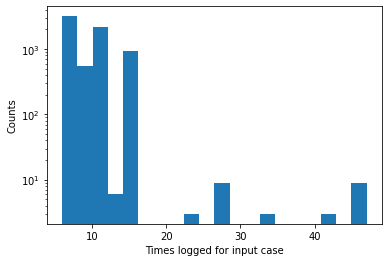

In [30]:
times_logged = np.diff(logs_df[logs_df["stage"] == "initialguess"].index)
_handle = plt.hist(times_logged, bins=20, log=True)
plt.xlabel("Times logged for input case")
plt.ylabel("Counts")
print("Number of times logged is a proxy for number of function calls.")

## Temp

In [141]:
''' TEMP: Making a figure '''
# solver = solver_from(100)
solver = solver_from_multi(1,1)

t = solver.time
# JANK: manually reconstruct the downsampled conservative variables
x, _U0 = mdtools.downsample(solver, "pDensityA")
_, _U1 = mdtools.downsample(solver, "pDensityWv")
_, _U2 = mdtools.downsample(solver, "pDensityM")
_, _U3 = mdtools.downsample(solver, "XMomentum")
_, _U4 = mdtools.downsample(solver, "YMomentum")
_, _U5 = mdtools.downsample(solver, "Energy")

rhow, p, T, _, _ = wlma.WLM_rhopT_native(
  np.concatenate((_U0, _U1, _U2), axis=-1),
  np.concatenate((_U3, _U4), axis=-1), _U5)
# Compute saturation properties for each point in the downsample
tuplize = lambda sat_obj: (sat_obj["psat"],
                           sat_obj["rho_satl"],
                           sat_obj["rho_satv"])
# Compute saturation information as a list of tuples for each point
sat_info = [tuplize(mixtureWLMA.float_mix_functions.prho_sat(_T))
            for _T in T.ravel()]
# Define map to steam fraction
fn_steamfrac = lambda rhow, sat_tup: np.clip(
 (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0
)
# Allocate psats, streamfrac
psats = np.empty_like(rhow)
steamfrac = np.empty_like(rhow)
# Extract saturation pressures
psats_tup, _, _ = zip(*sat_info)
# Fill np arrays
psats.ravel()[:] = np.array(psats_tup)
steamfrac.ravel()[:] = list(map(fn_steamfrac, rhow.ravel(), sat_info))
steamfrac = np.where(psats > 0, steamfrac, -1.0)

rhomix = _U0 + _U1 + _U2
u = _U3 / rhomix
v = _U4 / rhomix
velnorm = np.sqrt(u*u + v*v)
ya = _U0 / rhomix
yw = _U1 / rhomix
ym = _U2 / rhomix

# rhow.shape, p.shape, T.shape

clims = (0, 1)
mdtools.plot_mean(x, ya, clims)
# sm = plt.cm.ScalarMappable(
#   norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
#   cmap=plt.get_cmap())
# cb = plt.colorbar(sm)
# tl = plt.title(f"Air mass fraction at t = {1e3*t:.2f} ms")

solver = solver_from_multi(2,2)

t = solver.time
# JANK: manually reconstruct the downsampled conservative variables
x, _U0 = mdtools.downsample(solver, "pDensityA")
_, _U1 = mdtools.downsample(solver, "pDensityWv")
_, _U2 = mdtools.downsample(solver, "pDensityM")
_, _U3 = mdtools.downsample(solver, "XMomentum")
_, _U4 = mdtools.downsample(solver, "YMomentum")
_, _U5 = mdtools.downsample(solver, "Energy")

rhow, p, T, _, _ = wlma.WLM_rhopT_native(
  np.concatenate((_U0, _U1, _U2), axis=-1),
  np.concatenate((_U3, _U4), axis=-1), _U5)
# Compute saturation properties for each point in the downsample
tuplize = lambda sat_obj: (sat_obj["psat"],
                           sat_obj["rho_satl"],
                           sat_obj["rho_satv"])
# Compute saturation information as a list of tuples for each point
sat_info = [tuplize(mixtureWLMA.float_mix_functions.prho_sat(_T))
            for _T in T.ravel()]
# Define map to steam fraction
fn_steamfrac = lambda rhow, sat_tup: np.clip(
 (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0
)
# Allocate psats, streamfrac
psats = np.empty_like(rhow)
steamfrac = np.empty_like(rhow)
# Extract saturation pressures
psats_tup, _, _ = zip(*sat_info)
# Fill np arrays
psats.ravel()[:] = np.array(psats_tup)
steamfrac.ravel()[:] = list(map(fn_steamfrac, rhow.ravel(), sat_info))
steamfrac = np.where(psats > 0, steamfrac, -1.0)

rhomix = _U0 + _U1 + _U2
u = _U3 / rhomix
v = _U4 / rhomix
velnorm = np.sqrt(u*u + v*v)
ya = _U0 / rhomix
yw = _U1 / rhomix
ym = _U2 / rhomix

# rhow.shape, p.shape, T.shape

clims = (0, 1)
mdtools.plot_mean(x, ya, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
tl = plt.title(f"Air mass fraction at t = {1e3*t:.2f} ms")

## Water inspect

In [281]:
import float_phi_functions
plt.figure(figsize=(6,4), dpi=360)
T_range_subcrit = np.linspace(273.16, mixtureWLMA.Tc-1e-5, 121)
# T_range_supcrit = np.linspace(float_phi_functions.Tc, 1000 200)
# T_range = [*T_range_subcrit, *T_range_supcrit]
p_curve = np.array([
    float_phi_functions.prho_sat(T)["psat"] for T in T_range_subcrit])
depth = (p_curve / 1e3 / 9.8)
plt.plot(T_range_subcrit[T_range_subcrit > 373.15] - 273.15,
         -depth[T_range_subcrit > 373.15])
plt.xlabel("Equilibrium boiling point (deg C)")
plt.ylabel("Depth (m)")
plt.xlim(0, 400)

(0.0, 400.0)

In [ ]:
plt.figure(figsize=(9,6))
T_range_subcrit = np.linspace(273.16, mixtureWLMA.Tc-1e-5, 121)
# T_range_supcrit = np.linspace(float_phi_functions.Tc, 1000 200)
# T_range = [*T_range_subcrit, *T_range_supcrit]
p_curve = np.array([
    float_phi_functions.prho_sat(T)["psat"] for T in T_range_subcrit])
depth = (p_curve / 1e3 / 9.8)
plt.plot(T_range_subcrit[T_range_subcrit > 373.15] - 273.15,
         -depth[T_range_subcrit > 373.15])
plt.xlabel("Equilibrium boiling point (deg C)")
plt.ylabel("Depth (m)")
plt.xlim(0, 400)

## Animação

In [282]:
%matplotlib tk
mdtools.generate_anim(["submarine_proto_hydro1_atm1", "submarine_proto_hydro1_atm2"], #["submarine_proto2_atm1", "submarine_proto2_atm2"],
                      [],
                      "submarine_proto2_hydro1_log10p_new",
                      200,
                      "Pressure",
                      filter=lambda p, p0: np.log10(np.abs(p) + 1e-2) ,
                      initial=1,
                      stride=1,
                      is_high_detail=False)

Animation constructed


In [266]:
%matplotlib tk
''' Pressure animation '''
# Animation code, sourced locally
import matplotlib.animation as animation

# atm_names = ["submarine_proto_debrisflow1_atm1"]
# outfilename = "submarine_proto_debrisflow_test_1_redirect"
# atm_names = ["submarine_proto_debrisflow3_atm1"]
# outfilename = "submarine_proto_debrisflow3_vlog_redir"
atm_names = ["submarine_proto_hydro1_atm1"]
outfilename = "submarine_proto_hydro1_atm1_vlog"


num_frames = 100
filter=lambda x: x
initial=0
stride=2
is_high_detail=False

FFwriter = animation.FFMpegWriter()
fig = plt.figure(figsize=(11, 11), dpi=80)
FFsetup_failure = False
try:
  FFwriter.setup(fig, f"{outfilename}.mp4")
except:
  print("Failed to set up FFWriter. Showing plots without saving animation.")
  FFsetup_failure = True

atm_initials = [readwritedatafiles.read_data_file(f"{name}_{0}.pkl") 
  for name in atm_names]
conduit_initials = [readwritedatafiles.read_data_file(f"{name}_{0}.pkl") 
  for name in []]

''' Compute values for each frame '''
all_values = []
all_x = []
all_t = np.zeros((num_frames,))
for i in range(num_frames):
  read_index = initial+i*stride
  all_values.append([])

  for dom_idx, name in enumerate(atm_names):
    solver = readwritedatafiles.read_data_file(f"{name}_{read_index}.pkl")

    # Compute quantity
    # JANK: manually reconstruct the downsampled conservative variables
    x, _U0 = mdtools.downsample(solver, "pDensityA")
    # _, _U1 = mdtools.downsample(solver, "pDensityWv")
    # _, _U2 = mdtools.downsample(solver, "pDensityM")
    # _, _U3 = mdtools.downsample(solver, "XMomentum")
    # _, _U4 = mdtools.downsample(solver, "YMomentum")
    # _, _U5 = mdtools.downsample(solver, "Energy")
    # psats = np.empty_like(_U0)
    # steamfrac = np.empty_like(_U0)
    
    # # Extract saturation pressures
    # sat_info = [tuplize(mixtureWLMA.float_mix_functions.prho_sat(_T))
    #         for _T in T.ravel()]
    # psats_tup, _, _ = zip(*sat_info)
    # # Fill np arrays
    # psats.ravel()[:] = np.array(psats_tup)
    # steamfrac.ravel()[:] = list(map(fn_steamfrac, rhow.ravel(), sat_info))
    # steamfrac = np.where(psats > 0, steamfrac, -1.0)

    # Compute quantity in initial condition
    # _, qty_init = mdtools.downsample(atm_initials[dom_idx], plot_qty)
    # # Apply filter f(q, q0)
    # qty = filter(qty, qty_init)

    ''' Choose quantity here. '''
    qty = np.log10(mdtools.downsample(solver, "Velocity")[1] + 1e-16)
    # qty = _U2 / (_U0 + _U1 + _U2)
    all_values[i].append(qty)
    if i == 0:
      all_x.append(x)
    all_t[i] = solver.time

''' Compute global clim '''
min_val = np.min([np.min([np.min(vals_dom) for vals_dom in vals_t]) for vals_t in all_values])
min_val = -1.0
max_val = np.max([np.max([np.max(vals_dom) for vals_dom in vals_t]) for vals_t in all_values])
clims = (min_val, max_val)
# clims[0] = -1.0
# clims = (0, 1)

''' Generate plot '''
for i in range(num_frames):
  plt.clf()
  for dom_idx, name in enumerate(atm_names):
    mdtools.plot_mean(all_x[dom_idx], all_values[i][dom_idx], clims)
  
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  cb.set_label("log10 velocity")
  
  plt.title(f"t = {all_t[i]:.6f}")
  plt.axis("auto")
  plt.axis("equal")
  plt.pause(0.010)
  if i == 1:
    plt.show()
  plt.draw()

  # Grab frame with FFwriter
  if not FFsetup_failure:
    FFwriter.grab_frame()

if not FFsetup_failure:
  FFwriter.finish()
print("Animation constructed")

Animation constructed


In [272]:
%matplotlib tk
''' Steam frac animation '''
# Animation code, sourced locally
import matplotlib.animation as animation

# atm_names = ["submarine_proto_hydro1_atm1"]
# outfilename = "submarine_proto_hydro1_test_steamfrac_redirect"
# atm_names = ["submarine_proto_debrisflow1_atm1"]
# outfilename = "submarine_proto_debrisflow_test_1_steamfrac"
atm_names = ["submarine_proto_hydro1_atm1"]
outfilename = "submarine_proto_hydro1_atm1_steamfrac_redirect"

# num_frames = 200
# filter=lambda x: x
# initial = 0
# stride = 2
# is_high_detail=False
num_frames = 100
filter=lambda x: x
initial = 0
stride = 2
is_high_detail=False

FFwriter = animation.FFMpegWriter()
fig = plt.figure(figsize=(11, 11), dpi=80)
FFsetup_failure = False
try:
  FFwriter.setup(fig, f"{outfilename}.mp4")
except:
  print("Failed to set up FFWriter. Showing plots without saving animation.")
  FFsetup_failure = True

atm_initials = [readwritedatafiles.read_data_file(f"{name}_{0}.pkl") 
  for name in atm_names]
conduit_initials = [readwritedatafiles.read_data_file(f"{name}_{0}.pkl") 
  for name in []]

''' Compute values for each frame '''
all_values = []
all_values_2 = []
all_x = []
all_t = np.zeros((num_frames,))
for i in range(num_frames):
  read_index = initial+i*stride
  all_values.append([])
  all_values_2.append([])

  for dom_idx, name in enumerate(atm_names):
    solver = readwritedatafiles.read_data_file(f"{name}_{read_index}.pkl")
    # Compute quantity
    # JANK: manually reconstruct the downsampled conservative variables
    x, _U0 = mdtools.downsample(solver, "pDensityA")
    _, _U1 = mdtools.downsample(solver, "pDensityWv")
    _, _U2 = mdtools.downsample(solver, "pDensityM")
    _, _U3 = mdtools.downsample(solver, "XMomentum")
    _, _U4 = mdtools.downsample(solver, "YMomentum")
    _, _U5 = mdtools.downsample(solver, "Energy")
    psats = np.empty_like(_U0)
    steamfrac = np.empty_like(_U0)

    rhow, p, T, _, _ = wlma.WLM_rhopT_native(
      np.concatenate((_U0, _U1, _U2), axis=-1),
      np.concatenate((_U3, _U4), axis=-1), _U5)
    
    # Extract saturation pressures
    sat_info = [tuplize(mixtureWLMA.float_mix_functions.prho_sat(_T))
            for _T in T.ravel()]
    psats_tup, _, _ = zip(*sat_info)
    # Fill np arrays
    psats.ravel()[:] = np.array(psats_tup)
    steamfrac.ravel()[:] = list(map(fn_steamfrac, rhow.ravel(), sat_info))
    steamfrac = np.where(psats > 0, steamfrac, -1.0)
    # Compute quantity in initial condition
    # _, qty_init = mdtools.downsample(atm_initials[dom_idx], plot_qty)
    # # Apply filter f(q, q0)
    # qty = filter(qty, qty_init)

    ''' Choose quantity here. '''
    # qty = mdtools.downsample(solver, "Pressure")[1]
    # qty = _U0 / (_U0 + _U1 + _U2)
    qty = steamfrac

    ''' Secondary quantity '''
    i_where_psupercrit = np.any(steamfrac < 0, axis=1, keepdims=True).squeeze()

    all_values[i].append(qty)
    all_values_2[i].append(i_where_psupercrit)
    if i == 0:
      all_x.append(x)
    all_t[i] = solver.time

''' Compute global clim '''
min_val = np.min([np.min([np.min(vals_dom) for vals_dom in vals_t]) for vals_t in all_values])
max_val = np.max([np.max([np.max(vals_dom) for vals_dom in vals_t]) for vals_t in all_values])
clims = (min_val, max_val)
# clims = (0, 1)

''' Generate plot '''
for i in range(num_frames):
  plt.clf()
  for dom_idx, name in enumerate(atm_names):
    # Plot supercritical fluid region
    plt.set_cmap("inferno")
    clims = (0, 1)
    x, steamfrac, i_where_psupercrit = \
      all_x[dom_idx], all_values[i][dom_idx], all_values_2[i][dom_idx]
    mdtools.plot_mean(x[i_where_psupercrit, ...], 
                      steamfrac[i_where_psupercrit, ...], clims)
    plt.set_cmap("viridis")
    # Superimpose subcritical fluid steam fractions
    mdtools.plot_mean(x[~i_where_psupercrit, ...], 
                      steamfrac[~i_where_psupercrit, ...], clims)
      
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  cb.set_label("Steam fraction")
  
  plt.title(f"t = {all_t[i]:.6f}")
  plt.axis("auto")
  plt.axis("equal")
  plt.pause(0.010)
  if i == 1:
    plt.show()
  plt.draw()

  # Grab frame with FFwriter
  if not FFsetup_failure:
    FFwriter.grab_frame()

if not FFsetup_failure:
  FFwriter.finish()
print("Animation constructed")

C:\Users\Fredric\AppData\Local\Temp\ipykernel_7232\3079134366.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0


Animation constructed


### Test and calculator

In [ ]:
# Replicate initial condition
y = np.array([0.0, 1-1e-7, 1e-7])
h0, hmax = -400.0, 1000.0
mixture_spec_vol = lambda p, T: \
			y[0] * physics0.Gas[0]["R"] * T / p \
			+ y[1] / mixtureWLMA.float_mix_functions.rho_l_pt(p, T) \
			+ y[2] / (physics0.Liquid["rho0"] 
				* (1.0 + (p - physics0.Liquid["p0"])/physics0.Liquid["K"]))
soln = scipy.integrate.solve_ivp(
	lambda height, p:
		-9.8 / mixture_spec_vol(p, physics0.IC.T),
	[h0, hmax],
	[1e3*1600*9.8],
	#t_eval=eval_pts,
	dense_output=True)
# Cache the pressure interpolant
_pressure_interpolant = soln.sol

In [ ]:
# Colortest
plt.get_cmap("inferno")

In [80]:
# Setting: 20 MPa supersonic inlet
scipy.optimize.fsolve(lambda r: mixtureWLMA.float_mix_functions.p(r,1000)-20e6, 47)

array([45.695633185787855])

In [ ]:
''' Examine specific values '''
examine_state_idx = 0
# plt.scatter(U_ess[...,examine_state_idx], x[...,1].ravel())
p_try = physics0.compute_additional_variable("Pressure", U_ess1, False)
plt.scatter(p_try, x1[...,1].ravel())
offending_y = x1[...,1:2][np.where(np.isnan(p_try))].ravel()
dummy_val = np.ones_like(offending_y) * 2e6
plt.scatter(dummy_val, offending_y, c='r')
# dummy_val.shape, offending_y.shape
# dummy_val

In [ ]:
''' Isolate float_mix_functions low-level op '''
data = np.ascontiguousarray(np.stack((
      U_ess1[:,...,5:6],
      U_ess1[:,...,0:3].sum(axis=-1,keepdims=True),
      U_ess1[:,...,1:2]/U_ess1[:,...,0:3].sum(axis=-1,keepdims=True),
      U_ess1[:,...,0:1]/U_ess1[:,...,0:3].sum(axis=-1,keepdims=True)), axis=-1).ravel())
i = 0
R_a, gamma_a = physics0.wlma.R_a, physics0.wlma.gamma_a
for i in range(2):
      _p = data[4*i] * (gamma_a - 1.0)        # en / (gamma-1)
      data[4*i+2] = _p / (data[4*i+1] * R_a)  # p / (rho R)
      data[4*i+1] = _p
      data[4*i+3] = np.sqrt(gamma_a * R_a * data[4*i+2])
      data[4*i] = 0.0
np.isnan(data).sum()

_p = U_ess1[2,:,5:6] * (physics0.wlma.gamma_a - 1.0)
_T = _p / (U_ess[2,:,0:3].sum(axis=-1, keepdims=True) * physics0.wlma.R_a)
np.sqrt(physics0.wlma.gamma_a * physics0.wlma.R_a * _T)